# Práctica Machine Learning con Python

El ejercicio consiste en estudiar el churn de clientes en una empresa de telecomunicaciones. Hay una serie de clientes que de Diciembre de 2019 a Enero de 2020 han abandonado la empresa.

Tenemos que construir un modelo analítico que sea capaz de captar el perfil de aquellos clientes que abandonaron la empresa y así poder predecir los próximos clientes que son potenciales de marcharse, para poder lanzar una campaña fidelizadora. Además, tenemos que analizar las causas por las cuales los clientes se han fugado de la empresa.

Los datos asignados para desarrollar este ejercicio están dividos en 8 archivos, 4 para cada mes (clientes, consumos, financiacion y productos). Por lo que primeros tendremos que manipular estos subsets para que la información de la que disponemos esté estructurada de una forma que facilite trabajar con estos datos.

## Librerias utilizadas

In [124]:
import pandas as pd
import numpy as np

# fechas
from datetime import datetime

# web scraping
import requests

# text mining
from fuzzywuzzy import process

# V crammer
from scipy.stats import chi2_contingency

# gráficos
from plotnine import *
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Búsqueda y substitución de patrones.
import re

# IQR/Z score.
from scipy.stats import stats

# Seleción de variables.
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression 
from sklearn.feature_selection import chi2 
from sklearn.feature_selection import RFECV 

# Modelos Selección.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import StratifiedKFold 

# Modelos.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LinearRegression # Para el VIF.

# Preprocesado.
from sklearn.preprocessing import MinMaxScaler

# Métricas.
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report, plot_confusion_matrix

# Imputaciones.
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# Oversampling.
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

# Interacciones.
import patsy

# Graficar TREE.
from sklearn.tree import export_graphviz
import graphviz

## 1. Importamos los datos y construimos un único dataframe

Hay que tener en cuenta que la columna "antiguedad" contiene una fecha.
- Datos de Diciembre

In [2]:
dic_clientes = pd.read_csv("diciembre/clientes_diciembre.csv", sep = "|", parse_dates = ["antiguedad"])
dic_consumos = pd.read_csv("diciembre/consumos_diciembre.csv", sep = "|")
dic_fin = pd.read_csv("diciembre/financiacion_diciembre.csv", sep = "|")
dic_prod = pd.read_csv("diciembre/productos_diciembre.csv", sep = "|")

Uniremos los datos de los cuatro archivos cada mes utilizando la columna "id" presente en todos ellos. Hemos de tener en cuenta que no todos los clientes podrían estar en las otras tablas por lo que utilizaremos 'left joins' desde la tabla de clientes (esta debería contenerlos a todos).

In [3]:
dic_cl_con = pd.merge(dic_clientes, dic_consumos, on = "id", how = "left")
dic_cl_con_f = pd.merge(dic_cl_con, dic_fin, on= "id", how = "left")
dic_full = pd.merge(dic_cl_con_f, dic_prod, on = "id", how = "left")

- Datos de Enero

In [4]:
en_clientes = pd.read_csv("enero/clientes_enero.csv", sep = "|", parse_dates=["antiguedad"])
en_consumos = pd.read_csv("enero/consumos_enero.csv", sep = "|")
en_fin = pd.read_csv("enero/financiacion_enero.csv", sep = "|")
en_prod = pd.read_csv("enero/productos_enero.csv", sep = "|")

Nuevamente, uniremos los datos de enero utilizando la columna "id".

In [5]:
en_cl_con = pd.merge(en_clientes, en_consumos, on = "id", how = "left")
en_cl_con_f = pd.merge(en_cl_con, en_fin, on = "id", how = "left")
en_full = pd.merge(en_cl_con_f, en_prod, on = "id", how = "left")

Por ultimo, crearemos una nueva variable en cada dataset que indique el mes al que corresponde. Para así poder juntar ambos datasets y aplicar a todos los datos el mismo procesamiento.

In [6]:
dic_full["mes"] = "dic"
en_full["mes"] = "en"

#### Variable objetivo

Creación de la variable respuesta. Buscaremos los "id" de diciembre que siguen en la empresa en enero, asignando 0 si el cliente permanece o 1 si no está entre los clientes de enero.

In [7]:
dic_full["churn"] = np.where(dic_full.id.isin(en_full.id) == True, 0, 1)

A la hora de comprobar cuantos clientes abandonaron la empresa en enero, hemos de tener en cuenta también los clientes que entraron en ese mes y podrían estar ocultando fugas.

In [8]:
dic_full.shape[0], en_full.shape[0], len(dic_full) - dic_full.id.isin(en_full.id).sum()

(95467, 92711, 7085)

Se observa que en enero hubo una disminución de 3000 clientes aproximadamente. En cuanto a la fuga de clientes, un total de 7085 clientes abandonaron la empresa en enero.

Una vez creada la variable objetivo "churn", concatenaremos ambos datasets con el fin de realizar el mismo feature engineering en ambos meses. Con el argumento 'sort = False', la variable "churn" quedará en NaN en los meses de enero. Cuando se quiera separar enero y diciembre simplente se filtrará por la variable "mes".

In [9]:
data = pd.concat([dic_full, en_full], sort = False, ignore_index=True)
data

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,...,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV,mes,churn
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,NaN,NaN,110,79,...,12806,13751,NaN,NaN,NaN,FIBRA,50MB,tv-futbol,dic,0.0
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,NaN,NaN,189,89,...,6499,10862,NaN,NaN,SI,FIBRA,600MB,tv-futbol,dic,0.0
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,NaN,NaN,129,30,...,17013,16743,NaN,NaN,SI,ADSL,35MB,tv-futbol,dic,0.0
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,NaN,NaN,51,52,...,3393,6771,NaN,NaN,NaN,FIBRA,200MB,tv-familiar,dic,0.0
4,5,25,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NaN,183,3,...,18436,4485,NaN,NaN,NaN,ADSL,10MB,tv-futbol,dic,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188173,99996,36,215.890326,2013-04-09 13:33:00,Guadalajara,3,NaN,NaN,217,96,...,7735,8823,NaN,NaN,NaN,ADSL,30MB,tv-futbol,en,NaN
188174,99997,68,285.890750,2003-08-08 23:57:00,Asturias,5,NaN,NaN,168,99,...,4798,3996,SI,14.616422,NaN,FIBRA,200MB,tv-futbol,en,NaN
188175,99998,20,383.167610,2013-03-27 20:07:00,Álava,4,NaN,NaN,188,71,...,1237,16720,NaN,NaN,NaN,ADSL,20MB,tv-futbol,en,NaN
188176,99999,53,53.301395,2020-01-18 02:30:00,Sevilla,2,NaN,NaN,138,40,...,10552,17637,NaN,NaN,NaN,FIBRA,50MB,tv-futbol,en,NaN


## 2. Preprocesado y limpieza de datos

En un proyecto con datos reales antes de una limpieza sería más apropiado estimar la importancia de las variables con técnicas y estadísticos como la V de Cramer, Lasso o Random Forest (obviando NaN) y centrarse solo en variables que resultan ser importante. No obstante, en esta práctica limpiaremos todas las variables con fines didáctico, aún sabiendo que muchas de las generadas aleatoriamente no tienen ninguna relevancia a la hora de modelar la variable dependiente.

### 2.1 NaN

Al unir los datasets aparecen muchas variables con NaN. No obstante, no son Nan, sino clientes que no tienen líneas contratadas, no han tenido incidencias, no han necesitado financiación (por lo que su importe de financiacion es NaN tambien) o no tienen descuentos. Consecuentemente, en estos casos solo hay que cambiar los NaN por 0. Por otra parte, los NaN presentes en la varaible "churn" corresponden a los datos de enero, para los que no tenemos (ni necesitamos) dicha información.

In [10]:
print('Número de valores missing en cada variable:')
data.isnull().sum()

Número de valores missing en cada variable:


id                     0
edad                   0
facturacion            0
antiguedad             0
provincia              0
num_lineas             0
num_dt            179047
incidencia        180955
num_llamad_ent         0
num_llamad_sal         0
mb_datos               0
seg_llamad_ent         0
seg_llamad_sal         0
financiacion      175140
imp_financ        175140
descuentos        148986
conexion               0
vel_conexion           0
TV                     0
mes                    0
churn              92711
dtype: int64

In [11]:
# Filling NaN's with 0
data.fillna(0, inplace=True)

In [12]:
# Check
print('Número de valores missing en cada variable:')
data.isnull().sum()

Número de valores missing en cada variable:


id                0
edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
financiacion      0
imp_financ        0
descuentos        0
conexion          0
vel_conexion      0
TV                0
mes               0
churn             0
dtype: int64

In [13]:
data.loc[data["mes"]=='en', "churn"] = np.nan

Ahora que hemos limpiado los NaNs de nuestras features, podemos echar un primer vistazo a la importancia de las variables. La primera función la encontré en _stackoverflow_ y calcula la V de Cramer y la segunda fue desarrollada por Manuel Alda Martín-Mora, un antiguo compañero (es muy bueno, buscad su perfil y sus proyectos). La primera se modifica para hacer binning a las variables numéricas para y que se pueda computar la: 
\begin{align} 
\chi^2
\end{align}

Link:

[Cramer's V function][CsV]

[CsV]: [https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix]

In [14]:
# from scipy.stats import chi2_contingency
# import seaborn as sns
# import matplotlib.pyplot as plt

def cramers_v(x, y):
    
    if x.dtypes != "O":
        x = pd.cut(x, bins=5)
        
    if y.dtypes != "O":
        y = pd.cut(y, bins=5)
    
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def cramers_v_graphic(data, target, graph=True):
    
    vc = {}
    
    for i in range(len(data.columns)):
        vc[data.iloc[:,i].name] = cramers_v(data.iloc[:,i], target)
        
    vc = pd.DataFrame.from_dict(vc,orient="index",columns=["CramersV"]).sort_values(by="CramersV", ascending=False)
    
    if graph == True:
        return(sns.heatmap(vc.sort_values(by="CramersV", ascending=False),annot=True,fmt='.2f'))
    else:
        return(vc)


In [15]:
# Importancia de variables:
cramers_v_graphic(data.drop("mes", axis=1), dic_full["churn"], graph=False).head(10).style.background_gradient()

,CramersV
churn,0.999924
num_dt,0.560547
incidencia,0.500789
descuentos,0.141361
financiacion,0.074447
imp_financ,0.070821
antiguedad,0.010581
provincia,0.006229
vel_conexion,0.006210
TV,0.001186


En siguiente lugar, atenderemos a la correlación de las features con la variable objetivo como medida de la importancia de estas. En concreto, usaremos la correlación de Kendall puesto que nuestras features son numéricas y la variable respuesta es categórica, aunque es más adecuada la V Crammer con las numéricas tramificadas. En la práctica los resultados son muy parecidos, incluso si se hubiera hecho la correlación lineal de Pearson o Spearman.

In [16]:
corr = abs(dic_full.corr("kendall"))
corr[["churn"]].sort_values(by = "churn",ascending = False).style.background_gradient()

,churn
churn,1.000000
num_dt,0.015118
imp_financ,0.011295
num_llamad_ent,0.005023
num_llamad_sal,0.002579
edad,0.002349
facturacion,0.002313
num_lineas,0.001361
mb_datos,0.000977
id,0.000709


Tras un primer vistazo, parece que las variables que más pueden influir son número de líneas en impago ("num_dt") e incidencias. Así mismo, en menor medida, los descuentos y la financiación.

### 2.2 Integridad de los datos

A continuación, verificaremos que la media, máximo, mínimo, etc. de nuestras variables tengan sentido.

In [17]:
data.describe()

,id,edad,facturacion,num_lineas,num_dt,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,imp_financ,churn
count,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,95467.000000
mean,49995.915575,51.445902,207.440105,3.559353,0.121651,124.960580,49.942060,12499.843850,9984.887548,10030.097652,1.543039,0.074214
std,28868.075573,19.588371,111.291972,1.085952,0.592672,72.457194,29.163648,7228.701809,5768.944531,5774.962597,6.256868,0.262120
min,1.000000,18.000000,15.000439,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24980.000000,35.000000,111.370882,3.000000,0.000000,62.000000,25.000000,6205.000000,4983.000000,5032.000000,0.000000,0.000000
50%,49985.000000,51.000000,206.927616,4.000000,0.000000,125.000000,50.000000,12496.000000,9981.000000,10029.000000,0.000000,0.000000
75%,75005.750000,68.000000,304.388724,4.000000,0.000000,188.000000,75.000000,18764.000000,14974.000000,15020.000000,0.000000,0.000000
max,100000.000000,85.000000,399.998433,5.000000,4.000000,250.000000,100.000000,25000.000000,20000.000000,20000.000000,39.991954,1.000000


- seg_llamad_ent y seg_llamad_sal se comportan de manera similar en todos los estadísticos.
- Es extraño que los minimos de llamadas entrantes y llamadas salidas sean 0 cuando no hay nadie que tenga seg_llamad_ent 0 y seg_llamad_sal 0. Revisaremos esto.

In [18]:
data.loc[(data["num_llamad_ent"]==0) & (data["num_llamad_sal"]==0)]

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,...,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV,mes,churn
11913,12471,39,252.939149,2018-02-17 14:17:00,Guadalajara,4,0.0,0,0,0,...,16310,17131,0,0.000000,SI,FIBRA,200MB,tv-futbol,dic,0.0
26519,27776,47,239.651875,2009-01-15 08:33:00,Albacete,5,0.0,0,0,0,...,15584,5106,0,0.000000,0,FIBRA,50MB,tv-futbol,dic,0.0
60437,63288,57,375.419501,1999-09-05 02:45:00,Burgos,3,2.0,0,0,0,...,92,8292,0,0.000000,0,ADSL,20MB,tv-futbol,dic,1.0
92608,97012,67,50.161610,2003-06-19 10:12:00,Almería,3,0.0,0,0,0,...,19669,15572,0,0.000000,0,FIBRA,200MB,tv-futbol,dic,0.0
94518,99005,76,71.685347,2000-07-04 07:37:00,Guipúzcoa,3,0.0,0,0,0,...,9374,15148,0,0.000000,0,ADSL,15MB,tv-familiar,dic,0.0
114259,20256,66,316.898779,1997-10-23 12:54:00,Segovia,5,0.0,0,0,0,...,16093,17965,0,0.000000,SI,ADSL,25MB,tv-total,en,NaN
122344,28963,46,32.338928,2006-01-14 15:55:00,La Coruña,3,0.0,0,0,0,...,2354,19752,0,0.000000,SI,FIBRA,200MB,tv-familiar,en,NaN
123696,30415,25,290.200707,2012-08-12 19:39:00,Guadalajara,3,0.0,0,0,0,...,9164,17362,SI,39.160158,0,ADSL,25MB,tv-familiar,en,NaN
155091,64325,75,212.215195,2018-10-21 11:43:00,Cáceres,3,0.0,0,0,0,...,8803,7175,0,0.000000,0,FIBRA,100MB,tv-familiar,en,NaN
156962,66350,68,19.631087,2016-01-23 09:21:00,Castellón,3,0.0,0,0,0,...,10996,16893,0,0.000000,0,ADSL,20MB,tv-futbol,en,NaN


Descubrimos que estos clientes, los cuales tienen 0 llamadas tanto entrantes como salientes, tienen segundos registrados de llamadas entrantes y salientes. __Seguramente haya surgido porque los datos son aleatorios, pero se van a pasar a NA e imputar para practicar__.

In [19]:
# A NA.
data.loc[(data["num_llamad_ent"]==0) & (data["num_llamad_sal"]==0), ["num_llamad_ent","num_llamad_sal"]] = np.nan

Para imputar estos NaNs introducidos utilizaremos Extra Tres Regressor. Este algoritmo es muy similar a Random Forest (el cual abordaremos en el apartado de modelos) diferenciándose unicamente en la forma que hacen los splits los árboles. Como este ejercicio solo tiene el fin de practicar, usaremos 2 árboles por rapidez.

In [20]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.ensemble import ExtraTreesRegressor

# Llamadas entrantes:
imputer_ent = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=2, random_state=0),
    max_iter=2,
    random_state=0
)

# Llamadas salientes:
imputer_sal = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=2, random_state=0),
    max_iter=2,
    random_state=0
)

# Se introducen los datos.
imputer_ent.fit(data[["num_llamad_ent", "seg_llamad_ent", "seg_llamad_sal"]])
imputer_sal.fit(data[["num_llamad_sal", "seg_llamad_ent", "seg_llamad_sal"]])

# Se predice la variable con NA (y solo se reemplazan las filas donde haya NA). Como devuelve un np.array se pasa a DataFrame.
num_llamadas_ent = imputer_ent.transform(data[["num_llamad_ent", "seg_llamad_ent", "seg_llamad_sal"]])
num_llamadas_ent = pd.DataFrame(num_llamadas_ent, columns=[["num_llamad_ent", "seg_llamad_ent", "seg_llamad_sal"]])

num_llamadas_sal = imputer_sal.transform(data[["num_llamad_sal", "seg_llamad_ent", "seg_llamad_sal"]])
num_llamadas_sal = pd.DataFrame(num_llamadas_sal, columns=[["num_llamad_sal", "seg_llamad_ent", "seg_llamad_sal"]])

In [21]:
# La variable con los NaNs imputados esta en el primer index.
data["num_llamad_ent"] = num_llamadas_ent.iloc[:,0]
data["num_llamad_sal"] = num_llamadas_sal.iloc[:,0]

### 2.3 Fechas + Feature Engineering

<font color=red>__La fecha en este dataset no tiene importancia, es totalmente aleatoria. Por tanto, se va a adelantar el feature enineering del apartado 5º a la parte de limpieza para no alargar en exceso la práctica. Si bien lo apropiado es hacer limpieza, intentar un primer modelo, ver las métricas, realizar FE y ver si se mejora.__</font>

- Para trabajar con la variable "antiguedad", hemos de convertirla a numérica. Para ello, calcularemos el número de días trnascurridos desde el 31 de enero hasta el día en que el cliente se registró. Se podrían usar años alternativamente.
- Por otra parte, crearemos variables categóricas sobres mes y día de la semana. Así trataremos de capturar una posible estacionalidad y las anomalías que generalmente aparecen en fin de semanas.
- También recogeremos información sobre la hora como numérica y categórica.

In [22]:
# from datetime import datetime
# A días. Con datetime.now() daba problemas.
data["duracion"] = datetime(2020,1,31) - data["antiguedad"]
data["duracion"] = data.duracion.apply(lambda x: int(x.days))

# Month:
data["month"] = data.antiguedad.apply(lambda x: x.strftime("%B"))

# Lo mismo con día de la semana. 
data["dia"] = data.antiguedad.apply(lambda x: x.strftime("%A"))

# Recoger la info de la hora.
data["hora"] = data.antiguedad.apply(lambda x: int(x.hour))

# Categórica para poder tener interpretabilidad.
data["hora_bin"] = pd.cut(data["hora"], bins = [-1,6,12,18,23], labels = ["Madrugada", "Mañana", "Tarde", "Noche"])

# Se elimina la variable original pues ya está convertida a numérica.
data.drop(columns = "antiguedad", inplace = True)

### 2.4 Variables Objeto

Este tipo de variables suelen coincidir con las de naturaleza categórica pero no siempre es el caso, como por ejemplo, vel_conexion que es claramente numérica-continua.

    Primeras intuiciones:     
        - provincia - Agrupar en CCAA.
        - incidencia - Binaria 0 - 1. 
        - financiacion - Binaria 0 - 1.
        - descuentos - Binaria 0-1.
        - conexion - Binaria 0-1.
        - vel_conexion - Quitar MB y a numérica.
        - TV - Dummy.
        - num_lineas y num_dt: Tienen poco valores únicos, por tanto, podría pasarse a categórica/dicotómica dependiendo de su distribución.

In [23]:
def uniqueValues(data): # En vez de usar dtypes, función propia para estudiar también los valores únicos.
    for i in list(data.columns):
        print(f"{data[i].name} : {data[i].dtype} : {len(data[i].unique())}")

In [24]:
uniqueValues(data)

id : int64 : 99796
edad : int64 : 68
facturacion : float64 : 100522
provincia : object : 50
num_lineas : int64 : 5
num_dt : float64 : 5
incidencia : object : 2
num_llamad_ent : float64 : 255
num_llamad_sal : float64 : 105
mb_datos : int64 : 24985
seg_llamad_ent : int64 : 19998
seg_llamad_sal : int64 : 20001
financiacion : object : 2
imp_financ : float64 : 6738
descuentos : object : 2
conexion : object : 2
vel_conexion : object : 11
TV : object : 3
mes : object : 2
churn : float64 : 3
duracion : int64 : 9162
month : object : 12
dia : object : 7
hora : int64 : 24
hora_bin : category : 4


#### 2.4.1 Provincia

<font color=red>__Provincia en este dataset no tiene importancia, es totalmente aleatroria. Por tanto, se va a adelantar el feature enineering del apartado 5º a la parte de limpieza para no alargar en exceso la práctica. Si bien lo apropiado es hacer limpieza, intentar un primer modelo, ver las métricas, realizar FE y ver si se mejora.__</font> 

Utilizaremos web scraping para obtener una tabla con las provincias agrupadas por comunidad autónoma. Sería tedioso usar bucles y operadores lógicos para agrupar provincias en CCAA. Lo mejor es obtener una tabla del INE donde estén agrupadas y hacer un join al dataset. Se eliminan las filas de Ceuta y Melilla que no están en nuestros datos.

In [25]:
# import requests
url = "https://www.ine.es/daco/daco42/codmun/cod_ccaa_provincia.htm"
html = requests.get(url).content
df_list = pd.read_html(html)
ccaa = pd.DataFrame(df_list[-1])
ccaa

,CODAUTO,Comunidad Autónoma,CPRO,Provincia
0,01,Andalucía,4.0,Almería
1,01,Andalucía,11.0,Cádiz
2,01,Andalucía,14.0,Córdoba
3,01,Andalucía,18.0,Granada
4,01,Andalucía,21.0,Huelva
5,01,Andalucía,23.0,Jaén
6,01,Andalucía,29.0,Málaga
7,01,Andalucía,41.0,Sevilla
8,02,Aragón,22.0,Huesca
9,02,Aragón,44.0,Teruel


In [26]:
# Mantenemos solo las columnas de CCAA y Provincia y eliminamos Ceuta y Melilla 
ccaa = ccaa[["Comunidad Autónoma", "Provincia"]]
ccaa.drop(index=[50, 51, 52], inplace=True)

c:\Users\Javier\Desktop\Proyectos\flex\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Es importante que todas las provincias se llamen igual en las dos tablas. Por ello, se usa la librería fluzzywuzyy para calcular distancias entre palabras basándose en la distancia de Levenshtein. Por ejemplo, en los datos originales es Vizcaya y en la tabla del INE es Bizkaia. Para hacer match sin tener que hacerlo manualmente se crea la siguiente función:

In [27]:
# from fuzzywuzzy import process

def inspect_str_var(variable2Match, variableOptions, ratio = 85):
    
    var2M = variable2Match.unique()
    varO = list(variableOptions.unique())
    
    for str2Match in var2M:
        
        r = process.extract(str2Match, varO)
        
        if r[0][1] >= ratio:
            variable2Match = np.where(variable2Match == str2Match, r[0][0], variable2Match )
    
    return variable2Match

Antes de hacer la unión de esta nueva tabla con nuestros datos, hemos de comprobar que las provincias efectivamente coinciden.

In [28]:
# Check
sorted(inspect_str_var(ccaa.Provincia, data.provincia, ratio=50)) == sorted(data.provincia.unique())

True

Ahora es posible hacer un join a través "provincia", ya que las dos tablas tienen este indentificador único.

In [29]:
# Hacemos la transformación y renombramos columnas
ccaa["Provincia"] = inspect_str_var(ccaa.Provincia, data.provincia, ratio=50)
ccaa.rename(columns={"Provincia" : "provincia"}, inplace=True)
ccaa.rename(columns = {"Comunidad Autónoma" : "ccaa"}, inplace = True)

<ipython-input-29-71eed7111459>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Javier\Desktop\Proyectos\flex\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
# Hacemos la union con nuestros datos 
data = pd.merge(data, ccaa, on = "provincia", how = "left")

# Eliminamos la columna provincia
data.drop(columns = "provincia", inplace = True)

# Check
data.ccaa.value_counts()

Castilla y León                33688
Andalucía                      30367
Castilla-La Mancha             18522
Galicia                        15085
Cataluña                       14900
Comunitat Valenciana           11531
Aragón                         11246
País Vasco                     11232
Extremadura                     7569
Canarias                        7446
Navarra, Comunidad Foral de     3916
Asturias, Principado de         3906
Murcia, Región de               3898
Balears, Illes                  3763
Madrid, Comunidad de            3756
Rioja, La                       3693
Cantabria                       3660
Name: ccaa, dtype: int64

#### 2.4.2 vel_conexion

Esta característica en realidad no representa una categoría, sino una cantidad; por tanto, simplemente eliminaremos los caracteres "MB" y la convertiremos a numérica.

In [31]:
# import re

data["vel_conexion"] = data.vel_conexion.apply(lambda x: int(re.sub("MB", "", x)))
data.vel_conexion.head()

0     50
1    600
2     35
3    200
4     10
Name: vel_conexion, dtype: int64

### 2.5 Correlaciones

A continuación, revisaremos la correlación entre nuestras features en busca de posibles varaibles colineales.

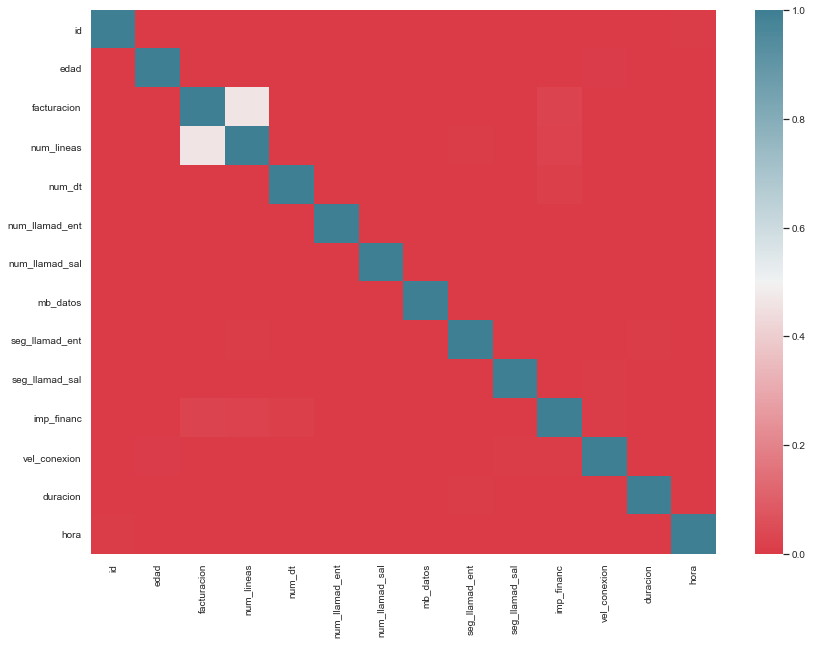

In [32]:
cor = abs(data.drop(columns="churn", axis=1).corr())
plt.figure(figsize=(14,10))
fig = sns.heatmap(cor, cbar=True, cmap=sns.diverging_palette(10, 220, as_cmap=True), vmin=0)

__Notas:__
    - No se observan correlaciones, excepto, num_lineas con facturación y es moderada. Seguramente esto sea debido a la aleatoriedad con que las variables fueron generadas.
    - Al no haber relaciones claras, se descartan métodos como Componentes Principales en la parte de feature engineering.

### 2.6 Outliers

En este apartado crearemos una función propia que permitirá mostrar los outliers en cada variable, pasarlos a NaN o hacer _camping_. Esta función se basa en el método del rango intercuartílico para detectar outliers, el cual es robusto a distribuciones asimétricas. No obstante, podemos encontrar casos en los que el rango intercuartílico sea 0 porque mas de la mitad de los valores de esta variable sean 0. En ese caso, usaremos el estadístico _Z score_, el cual consiste que en restar a cada observación su media y dividir el resultado por la desviación típica.

Método del rango intercuartílico:

\begin{align}
\ Outlier < IºQuantile - 1.5/3*IQR
\end{align}
\begin{align}
\ Outlier > IIIºQuantile + 1.5/3*IQR
\end{align}

   - Realizar camping consiste en sustituir un outlier al extremo del bigote superior o inferior que aparecería en un boxplot (outlier -> 3Q + 1.5*IQR / 1Q - 1.5*IQR).

Por otro lado con Z score:
    
\begin{align}
\ Z_{i} = \dfrac{x_{i}-\mu_x}{\sigma_x}; outlier: Z>3
\end{align}

In [33]:
# from scipy.stats import stats

def outliers(data, action, intensity = 3):
    
    # action = ["show","nan","camping"]
    
    qnt = np.quantile(data, q=[0.25,0.75])
    
    iqr = stats.iqr(data, nan_policy="omit")
    
    whisker = intensity * iqr
    qnt_1 = qnt[0] - whisker
    qnt_3 = qnt[1] + whisker  
    z = np.abs(stats.zscore(data.dropna()))    
 
    if action == "show" and iqr != 0:
        return print(f"{data.name}: {data.iloc[np.where((data>qnt_3) | (data<qnt_1) )].value_counts().sum()}")
    elif action == "show" and iqr == 0:
        return print(f"{data.name}: {data.iloc[np.where(z>3)].value_counts().sum()}, Warning IQR = 0")
    
    if action == "nan" and iqr != 0:
        data = np.where((data>qnt_3) | (data<qnt_1), np.nan, data)
        return data
    elif action == "nan" and iqr == 0:
        data = np.where((z>3), np.nan, data)
        return data
             
    if action == "camping" and iqr != 0:
        data = np.where(data>qnt_3, qnt[1] + 1.5*iqr, data)
        data = np.where(data<qnt_1, qnt[0] - 1.5*iqr, data)
        return data 
    elif action == "camping" and iqr == 0:
        data = np.where(data==0, 0, 1)
        return data

In [34]:
# Seleccionamos las variables numéricas
num_vars_names = data.loc[:,data.columns!="churn"]._get_numeric_data().columns
index = [data.columns.get_loc(i) for i in num_vars_names if i in data]

# Check
num_vars_names

Index(['id', 'edad', 'facturacion', 'num_lineas', 'num_dt', 'num_llamad_ent',
       'num_llamad_sal', 'mb_datos', 'seg_llamad_ent', 'seg_llamad_sal',
       'imp_financ', 'vel_conexion', 'duracion', 'hora'],
      dtype='object')

In [35]:
# Ahora visualizaremos los inputs detectados en cada variable
print('Outliers extremos - Intesidad: 1.5:\n')
for i in range(len(index)):
    outliers(data.iloc[:, index[i]], action="show", intensity=3)

print('\n\nOutliers leves - Intesidad 3:\n')    
for i in range(len(index)):
    outliers(data.iloc[:, index[i]], action="show", intensity=1.5)

Outliers extremos - Intesidad: 1.5:

id: 0
edad: 0
facturacion: 0
num_lineas: 0
num_dt: 6841, Warning IQR = 0
num_llamad_ent: 0
num_llamad_sal: 0
mb_datos: 0
seg_llamad_ent: 0
seg_llamad_sal: 0
imp_financ: 7101, Warning IQR = 0
vel_conexion: 0
duracion: 0
hora: 0


Outliers leves - Intesidad 3:

id: 0
edad: 0
facturacion: 0
num_lineas: 5611
num_dt: 6841, Warning IQR = 0
num_llamad_ent: 0
num_llamad_sal: 0
mb_datos: 0
seg_llamad_ent: 0
seg_llamad_sal: 0
imp_financ: 7101, Warning IQR = 0
vel_conexion: 18923
duracion: 0
hora: 0


__Notas__:
   - Encontramos outliers extremos tanto en número de líneas en impago como en importe de financiación.
   - En el caso de número de líneas en impago (num_dt) esto no son realmente outliers, el problema es que hay tantos clientes con 0 líneas en impago que esto afecta a los resultados, de tal manera que los clientes con 2 o más líneas en impago son considerados outliers. Probablemente lo más adecuado será crear una versión binaria de este variable que indique si un cliente tiene líneas en impago.
   - En cuanto al importe de financiación, encontramos un caso similar, donde 175 mil de las 188 mil observaciones de las que disponemos tienen valor 0, por lo que la mayoría de valores distintos de 0 son considerados outliers. En este caso lo más adecuado sería crear una variable binaria, no obstante, ya existe "financiación".
   - El resto de outliers detectados son leves y no es necesario aplicarles ningún tipo de tratamiento.

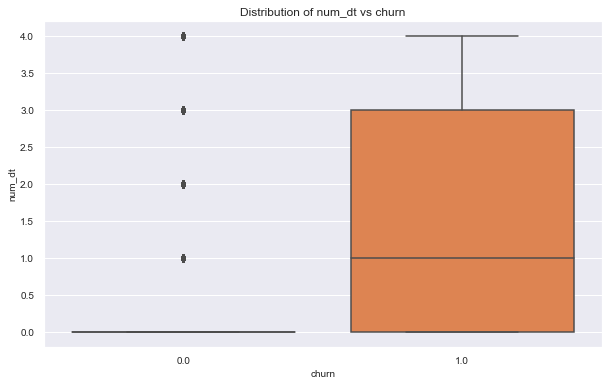

In [36]:
# Revisaremos la distribución de la variable "num_dt" sobre la variable objetivo
plt.figure(figsize=(10,6))

plt.title("Distribution of num_dt vs churn")
fig = sns.boxplot(x="churn", y="num_dt", data=data, saturation=1)

Efectivamente, confirmamos la importancia del número de líneas en impago de un cliente para determinar si éste es una fuga potencial. Por tanto, crearemos una versión binaria de esta variable que indique si un cliente tiene líneas en impago o no.

In [37]:
data["num_dt_bin"] = outliers(data.num_dt, "camping") # Ver función para ver que se convierte en binaria y no se hace camping.
data.num_dt_bin.value_counts()

0    179047
1      9131
Name: num_dt_bin, dtype: int64

En cuanto a la velocidad de conexión, sólo los usuarios con la máxima velocidad de conexión son considerados outliers (aquellos con 600 MB). Además, éstos casos son ejemplos de outliers leves, por lo que no es necesario aplicarles ninguna transformación. (Igualmente, esta variable es totalmente aleatoria y no tiene efecto sobre la target, tal y como vemos en el siguiente _boxplot_ ).

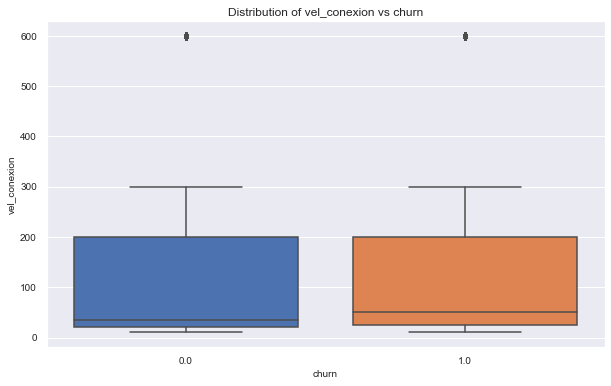

In [38]:
# Revisaremos la distribución de la variable "vel_conexion" sobre la variable objetivo
plt.figure(figsize=(10,6))

plt.title("Distribution of vel_conexion vs churn")
fig = sns.boxplot(x="churn", y="vel_conexion", data=data, saturation=1)

### 2.7 EDA

En siguiente lugar haremos un rápido EDA de las features de nuestro dataset, centrándonos en aquellas que hasta ahora se han mostrado más importantes.

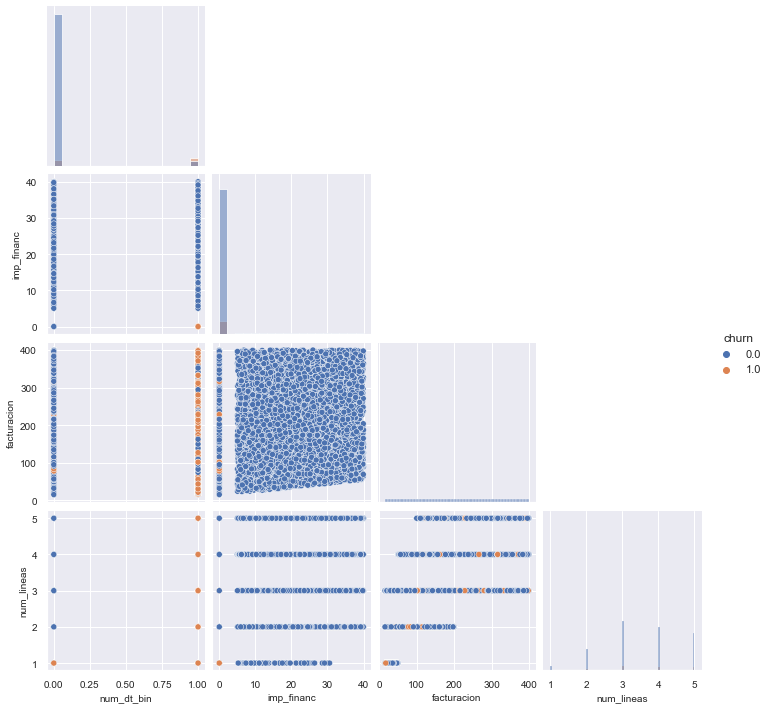

In [39]:
fig = sns.pairplot(data.loc[data["mes"] == "dic",  ["num_dt_bin", "imp_financ","facturacion", "num_lineas", "churn"]], 
                   hue="churn", diag_kind="hist", corner=True)

Notas:
- En este _pairplot_ resulta interesante la diagonal principal, que representa el comportamiento de la variable frente a la objetivo.
- Se pone de manifiesto la importancia de num_dt_bin. La mayoría de los clientes que se fueron en enero presentaban el impago de al menos una línea.
- Facturación y num_líneas no son relevantes, pero resulta interesante representan su correlación moderada (tal y como sería de esperar si estos datos fueran reales).

Por otro lado, ante la distribución tan asimétrica de imp_financ se intenta mejorarla con BoxCox pero ante una variable con tantos 0 no da buenos resultados. Tampoco mejora en su versión logarítmica. Se le suma +1 debido a:

\begin{align}
log(0) = \epsilon_{rror}
\end{align}
\begin{align}
log(1) = 0
\end{align}
    
Por ende, los 0 siguen siendo 0.

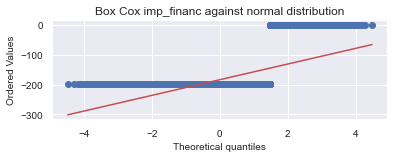

In [40]:
from scipy import stats

fig = plt.figure()

ax1 = fig.add_subplot(211)
xt,_ = stats.boxcox(data["imp_financ"]+0000.1)
# xt = np.log(data.imp_financ+1)
# xt = data.imp_financ

prob = stats.probplot(xt, dist=stats.norm, plot=ax1)
_ = ax1.set_title('Box Cox imp_financ against normal distribution')

- Los gráficos de log y boxcox no mejoraron el resultado.
- La línea azul debería sobreponerse a la roja para igualar a la de los cuartiles teóricos de una distribución normal.

En siguiente lugar, nos centraremos en las variables categóricas que han demostrado tener un efecto sobre la target y en aquellas que sospechamos que podrían influir en nuestra variable objetivo. Para ello, utilizaremos "ggplot", una paquete que nos permite graficar nuestras variables y sus relaciones y está construido sobre la famosa librería "ggplot2" del lenguaje R.

- Incidencia

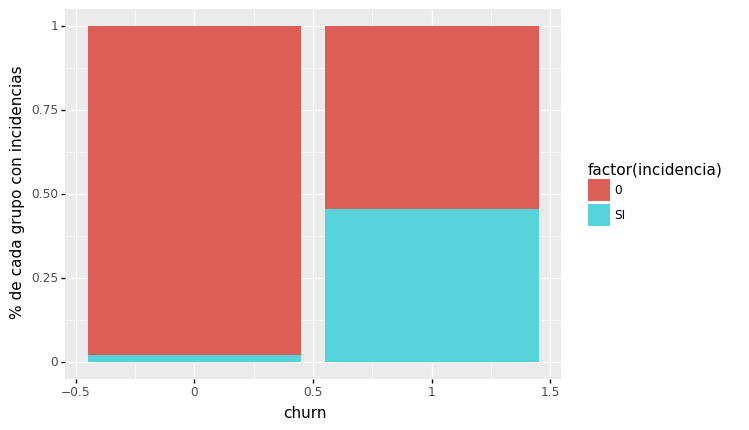

<ggplot: (155334254930)>

In [41]:
ggplot(data[data["mes"]=="dic"], aes("churn", fill="factor(incidencia)")) + \
                                 geom_bar(position="fill") + labs(y="% de cada grupo con incidencias")

Como vemos en el gráfico propuesto, aquellos clientes que comunican al menos una incidencia son mucho más probables de abandonar la empresa que aquellos que no han presentado incidencias.

- Descuentos

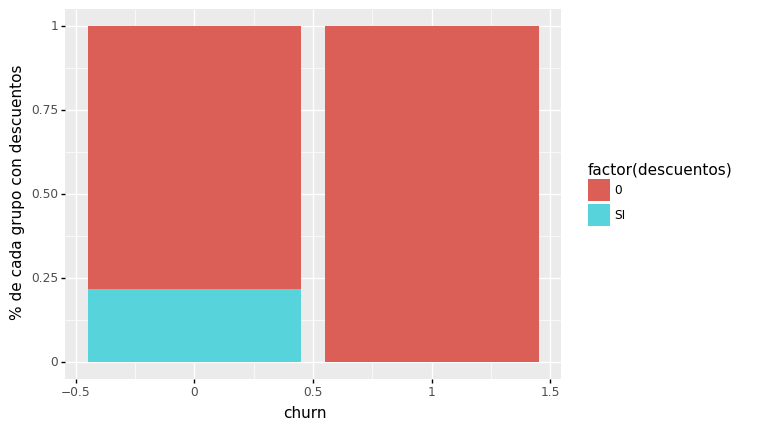

<ggplot: (155332874424)>

In [42]:
ggplot(data[data["mes"]=="dic"], aes("churn", fill="factor(descuentos)")) + \
                                 geom_bar(position="fill") + labs(y="% de cada grupo con descuentos")

A la vista de este gráfico, podemos confirmar la importancia de los descuentos, dado que todos los clientes que abandonaron la empresa no gozaban de descuentos.

- Financiación

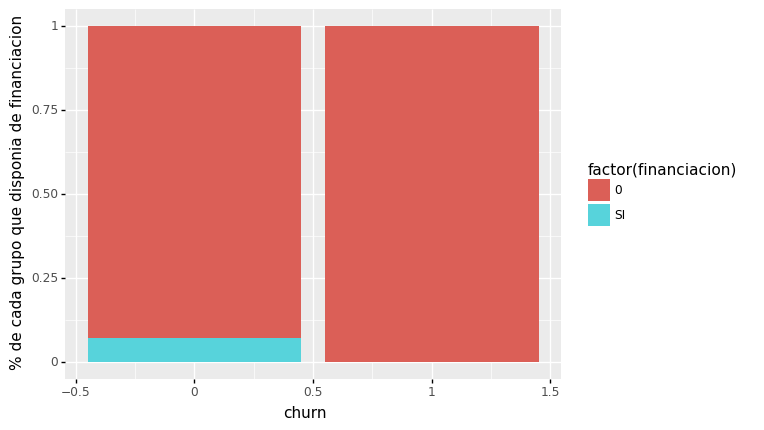

<ggplot: (155332876388)>

In [43]:
ggplot(data[data["mes"]=="dic"], aes("churn", fill="factor(financiacion)")) + \
                                 geom_bar(position="fill") + labs(y="% de cada grupo que disponia de financiacion")

Vemos unos resultados similares a los del caso anterior, todos los clientes que abandonaron la empresa no disponían de ningún tipo de financiación.

- Número de líneas en impago (binaria)

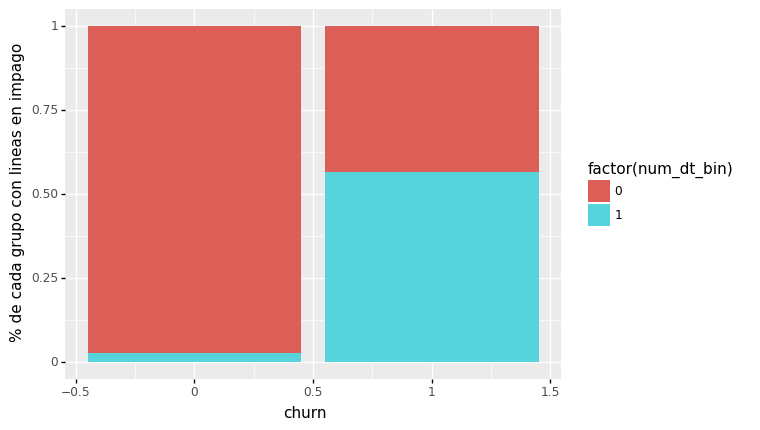

<ggplot: (155332876409)>

In [44]:
ggplot(data[data["mes"]=="dic"], aes("churn", fill="factor(num_dt_bin)")) + \
                                 geom_bar(position="fill") + labs(y="% de cada grupo con lineas en impago")

A la vista de estos resultados, podemos confirmar que la nueva variable número de incidencias binaria es claramente influyente.

- Conexión

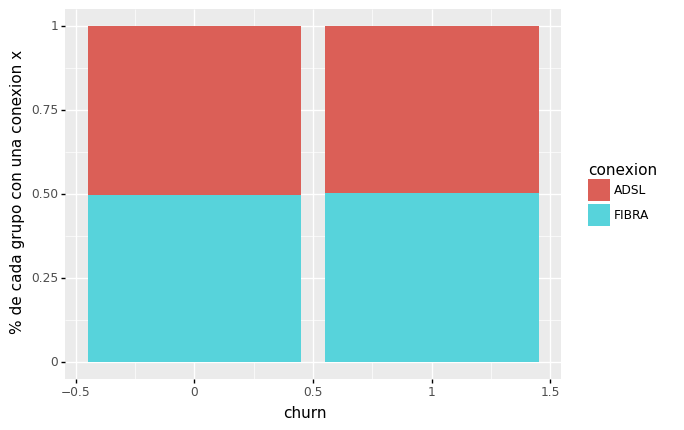

<ggplot: (155329892289)>

In [45]:
ggplot(data[data["mes"]=="dic"], aes("churn", fill="conexion")) + \
                                 geom_bar(position="fill") + labs(y="% de cada grupo con una conexion x")

Por otra parte, podemos ver en la variable "conexion" un claro ejemplo de variable que no tiene efecto sobre la target.

A continuación, obtendremos una rápida idea de la distribución de nuestra variable objetivo.

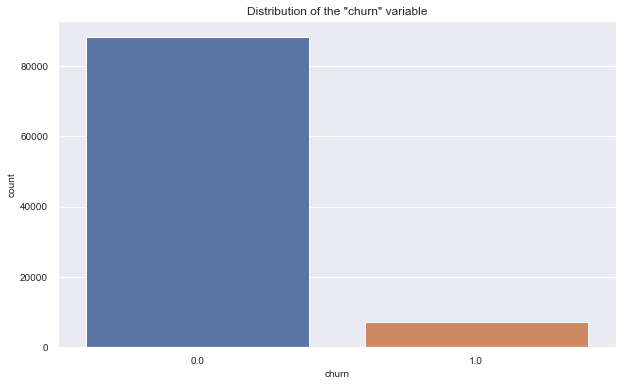

In [46]:
# Distribution of the "churn" variable
plt.figure(figsize=(10,6))

fig = sns.countplot(x="churn",data=data)
_ = plt.title('Distribution of the "churn" variable')

In [47]:
print('Solo un {}% de nuestras observaciones son clientes que efectivamente abandonaron la empresa.'.\
      format(round(sum(data.churn==1)/sum(data.churn==0)*100,2)))

Solo un 8.02% de nuestras observaciones son clientes que efectivamente abandonaron la empresa.


Ahora, a modo de práctica, construiremos un gráfico que refleje la correlación vista entre las variables "num_lineas", "financiacion" e "imp_financ".

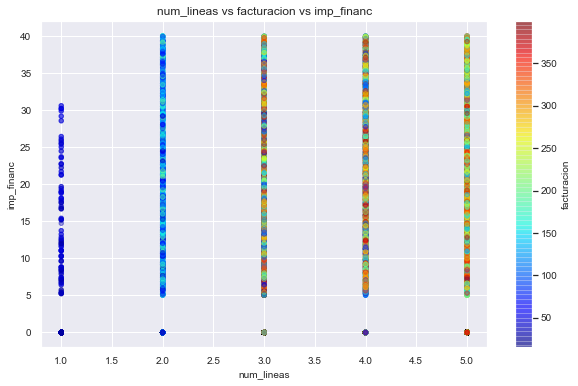

In [48]:
fig = data.plot(kind="scatter", x="num_lineas", y="imp_financ", alpha=0.4,
    figsize=(10,6), title='num_lineas vs facturacion vs imp_financ',
    c="facturacion", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

Por último, utilizaremos la función vista en clase para graficar la distribución de cada variable y la distribución de la variable objetivo sobre cada uno de los valores de éstas.

In [49]:
def proporciones_final (var,target,df):

    proporcion = pd.DataFrame()
    
    proporcion['%depositos'] = df[target].groupby(df[var]).mean()*100
    proporcion['Conteo'] = df[target].groupby(df[var]).count()
    proporcion= proporcion.round(3)   
    proporcion_filtered = proporcion[(proporcion['%depositos']>0) & (proporcion['Conteo']>10)]  
        
    if len(proporcion_filtered)<100 and len(proporcion_filtered)>1:
        fig = plt.figure()
        ax = proporcion_filtered['Conteo'].plot(kind='bar',grid=True)
                
        ax2 = ax.twinx()
        ax2.plot(proporcion_filtered['%depositos'].values, linestyle='-', linewidth=2.0,color='g')
        plt.ylim(0, 100) # modificación.
        plt.tight_layout()   
        
    else:        
        proporcion_filtered.reset_index(inplace=True)
        sns.lmplot(x = var,y ='%depositos', data=proporcion_filtered,fit_reg=True,ci=None)

<ipython-input-49-6ecb1e265a96>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


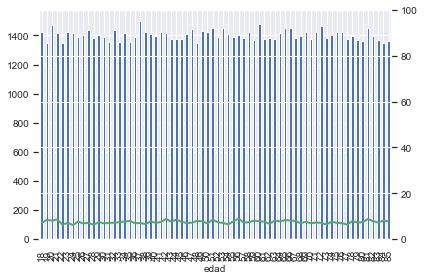

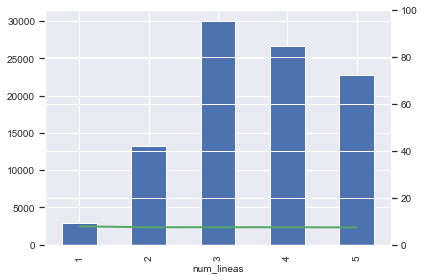

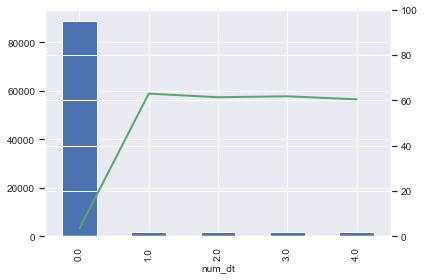

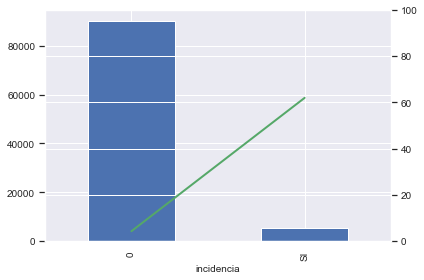

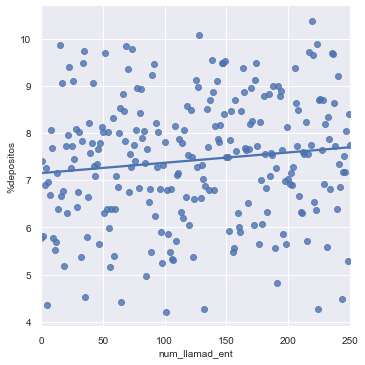

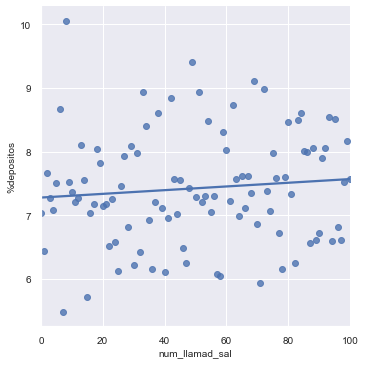

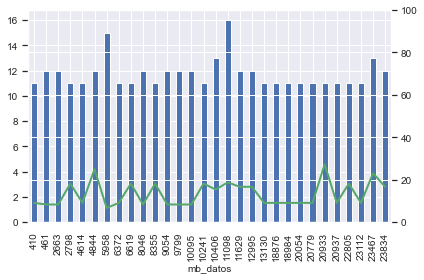

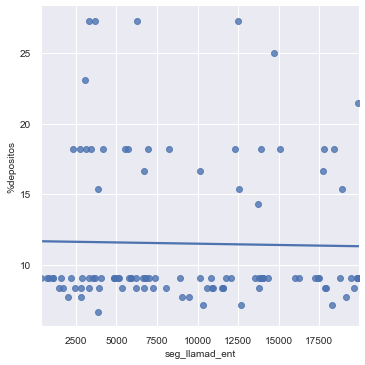

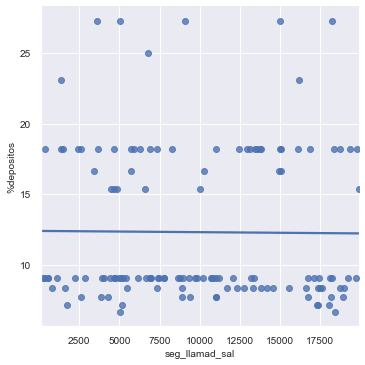

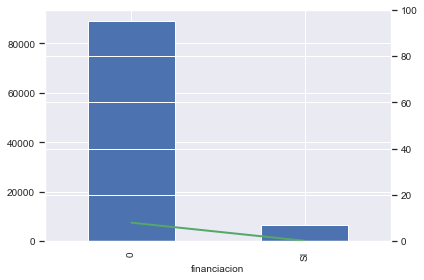

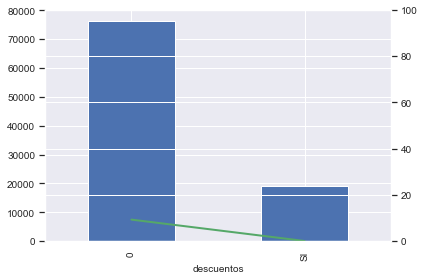

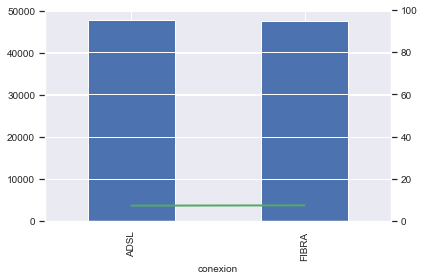

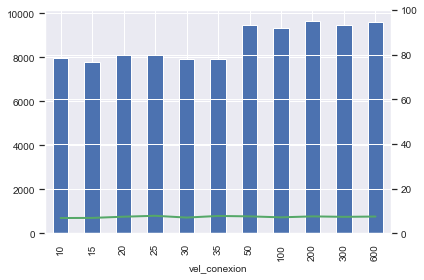

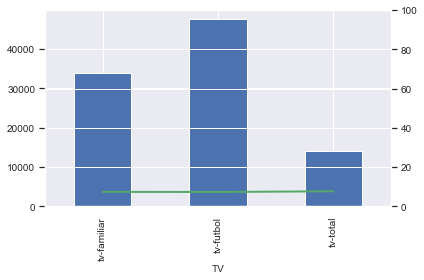

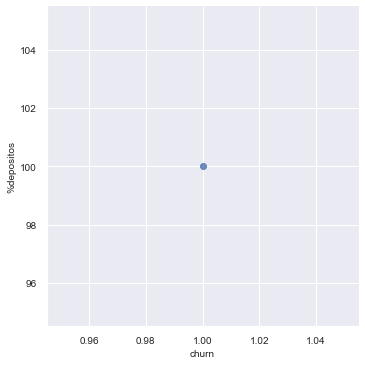

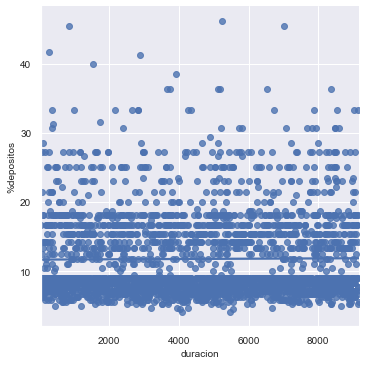

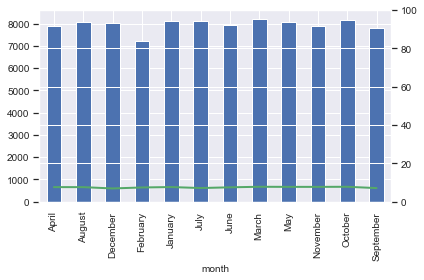

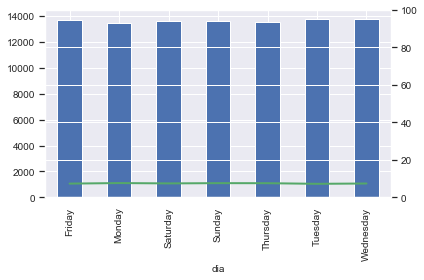

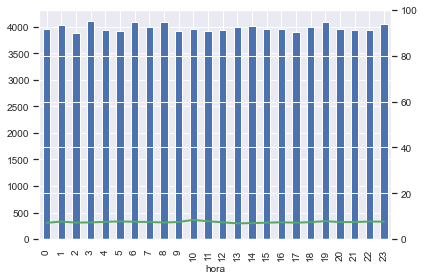

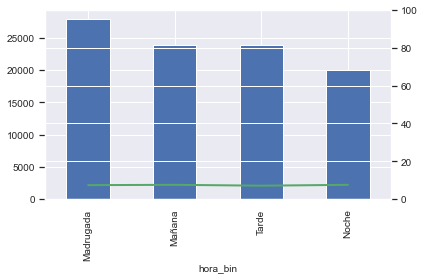

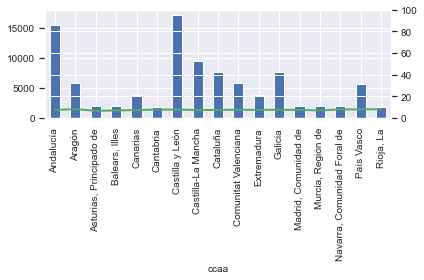

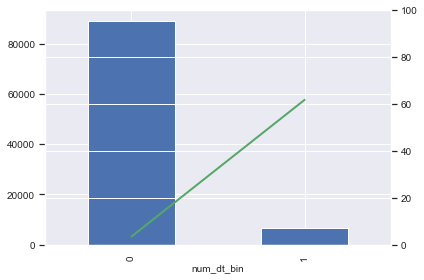

In [50]:
for i in data.drop(["mes", "id", "imp_financ", "facturacion"], axis=1).columns:
    proporciones_final (i, 'churn', data)

### 2.8 Variables Categóricas -> Dummies

La última transformación que realizaremos en este apartado consistirá en generar dummies para representar cada clase en nuestras variables categóricas. Para seleccionar estas variables, definiremos una simple función que devuelva una lista con las variables de tipo "object/category" y realizaremos una máscara sobre nuestros datos.

Nótese que por cada variable categórica eliminamos una categoría para evitar problemas de colinealidad, la categoría eliminada sería considerada entonces la clase de "base".

Tras esta transformación, todos nuestros datos serán númericos (excepto la variable "mes" que necesitaremos posteriormente para splitear los meses).

In [51]:
def categoriesNames(data):
    cat = []
    for i in list(data.columns):
        if data[i].dtype == 'object' or data[i].dtype.name == "category":
            cat.append(data[i].name)
    return cat

# Se guardan los nombres de las categóricas:
cat_vars_names = categoriesNames(data.loc[:,data.columns!="mes"])

# Creamos dummies a partir de estas variables:
cat_vars = pd.get_dummies(data[cat_vars_names], drop_first = True)

# Concatenamos estas nuevas variables al data set original:
data_dummy = pd.concat([data, cat_vars],axis=1)

# Eliminamos la version original de estas variables:
data_dummy.drop(columns=cat_vars_names, inplace=True)

## 3. División en conjuntos de train y test

LLevaremos a cabo un muestreo estratificado en función de la variable respuesta para que en los splits sus categorías estén bien representadas.
- Split 80/20

In [52]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_dummy.loc[data_dummy.mes=="dic",:].drop(["mes", "churn"], axis=1),
    data_dummy.loc[data_dummy.mes=="dic", "churn"],
    stratify = data_dummy.loc[data_dummy.mes=="dic", "churn"],
    random_state=3970,
    test_size=0.2
)

## 4. Construir un modelo analítico de clasificación que sea capaz de predecir cuando un cliente se fuga de la empresa, argumentando el tipo de algoritmo utilizado, las variables seleccionadas, obteniendo las métricas oportunas…

Como primera elección, escogeremos el modelo de __Árbol de Decisión__.

- Es un algoritmo que clasifica las observaciones en grupos maximizando la homogeneidad intra-grupo en función de una medida de impureza.

- Para llevar a cabo esta clasificación el modelo:
    1. Selecciona la variable más predictiva en función de un índice de impureza.
    2. Separa las observaciones en dos grupos según dicha variable.
    3. Repite el proceso con la segunda variable más influyente, y así sucesivamente proporcionando un algoritmo iterativo hasta que todas las observaciones son clasificadas.
    
    
- Las diferentes particiones de los grupos del árbol se denominan nodos:

    1. __Nodo raiz__: Primer grupo con todas las observaciones.
    2. __Nodos terminales__: Los que no se dividen más y dan la clasifiación final.
    
    
- Para partir los nodos se sigue un criterio fundamental: _"que los nodos hijos sean más puros que los nodos padres. Se introduce la idea de medida de impureza:_

    1. Cuandos los nodos son heterogéneos discriminan mejor la variable respuesta. Para medir esa heterogeneidad el índice más común es el de gini:
        \begin{align}
        I(N) = 2P*(1-P)
        \end{align}
        Donde P es la frecuencia/probabilidad de la variable respuesta. Por lo tanto, cuanto menor sea gini, más discrimina la variable y mejor clasificación se consigue.
    2. Por tanto, la influyencia de las variables se mide en cuanto más bajen el íncide de gini.
    3. Otro criterio similar es el de entropía.
    
¿Por qué Árbol de Decisión como primer modelo?

1. Rápido. Incluso con todas las variables del dataset.
2. Fácil de interpretar.
3. Identifican interacciones entre variables.
4. Identifican patrones es situaciones de alta dimensionalidad.
5. Robusto a valores atípicos (los aislan rapidamente).
6. Robusto a distribuciones asimétricas/sesgadas.
7. No requieren un gran preporcesamiento de datos.
8. Cuando los datos lo permiten, un PCA previo ayuda a los árboles a discriminar mucho mejor.
9. Son la base de los algoritmos más competitivos hoy en día.


Desventajas: __Aprenden tan bien las particularidades de los datos que se sobreajustan con mucha facilidad. Por ello, se suelen "podar".__

In [53]:
# from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report, plot_confusion_matrix

def obtener_metricas(y_real, y_pred): 
    print(f'- Matriz de confusión:\n {confusion_matrix(y_real, y_pred)}')
    print(f'- Accuracy: {accuracy_score(y_real, y_pred)}')
    print(f'- Precision/sensibilidad: {precision_score(y_real, y_pred)}')
    print(f'- Recall/especificidad: {recall_score(y_real, y_pred)}')
    print(f'- F1: {f1_score(y_real, y_pred)}')
    false_positive_rate, recall, thresholds = roc_curve(y_real, y_pred)
    roc_auc = auc(false_positive_rate, recall)
    print(f'- AUC: {roc_auc}')
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

Ahora construiremos una primera versión de nuestro modelo incluyendo todas las variables y lo evaluaremos mediante distintas métricas.

- Matriz de confusión:
 [[17414   263]
 [  279  1138]]
- Accuracy: 0.9716141196187283
- Precision/sensibilidad: 0.8122769450392576
- Recall/especificidad: 0.803105151729005
- F1: 0.8076650106458482
- AUC: 0.8941135307776664


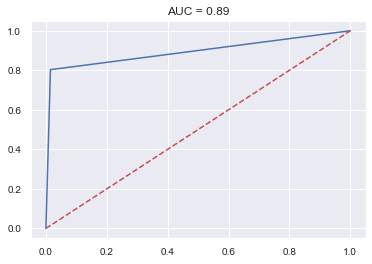

In [54]:
# from sklearn.tree import DecisionTreeClassifier

# Modelo y predicciones:
tree_mod = DecisionTreeClassifier(criterion="gini").fit(x_train, y_train)
tree_pred = tree_mod.predict(x_test)

# Métricas:
obtener_metricas(y_test, tree_pred)

Métricas de evaluación estimadas:
    - Matriz de confusión: refleja el número de predicciones de positivos y negativos correctas (diagonal) e incorrectas (diagonal inversa).
    - Sensibilidad o capacidad del modelo de identificar verdaderos positivos, 0.8145%. Ésta es la métrica que interesa a la compañía y aquella que intentaremos mejorar con técnicas de oversampling en el siguiente apartado.
    - Especificidad o capacidad de detectar verdaderos negativos, 0.7967%.
    - F1: Es la media ponderada entre especificidad y sensibilidad, que denota un modelo aceptable.
    - AUC: Se calcula con la sensibilidad y 1-especificidad (tasa de falsos positivos) por cada uno de los puntos de cortes posibles (es decir de 0 a 1). Lo que queda debajo es el área de la curva, que va de 0.5 a 1 porque el plano está partido por la mitad como se observa en el gráfico. Un AUC de 0.5 es un modelo que clasifica aleatoriamente, mientras que 1 es el calsificador perfecto, siendo este de 0.8911
    
- Fórmulas:

\begin{align}
Sensibilidad = \dfrac{VP}{VP+FN}
\end{align}

\begin{align}
Especificidad = \dfrac{VN}{VN+FP}
\end{align}

\begin{align}
F1 = 2*\dfrac{S*E}{S+E}
\end{align}

<font color=red>__NO SE DEBE USAR LA ACCURACY como métrica, ya que en la variable respuesta apenas hay un 8% de fugas, lo que quiere decir, que un modelo que solo predijese que los clientes se quedan, obtendría alrededor de un 92% de accuracy (éste es un ejemplo de los problemas derivados del desbalanceo de clases).__</font> 

En siguiente lugar, contruiremos de nuevo el mismo modelo de Árbol de Decisión, pero esta vez sólo incluiremos las variables que reflejaron un efecto sobre la target en el EDA y demás secciones anteriores.

Además, para conseguir unos resultados más robustos utilizaremos también una validación cruzada y estimaremos, además de el AUC como métrica de evaluación, la desviación típica de éste resultado.

Variables que incluiremos:
- num_dt_bin (número de líneas en impago, si o no)
- financiacion_SI (1 si el cliente tiene financiado algún servicio)
- descuentos_SI (1 si el cliente tiene algún descuento)
- incidencia_SI (1 si el cliente ha presentado alguna incidencia)
- imp_financ (importe de la financiación que recibe el cliente)

- Matriz de confusión:
 [[17369   308]
 [   16  1401]]
- Accuracy: 0.9830313187388708
- Precision/sensibilidad: 0.8197776477472206
- Recall/especificidad: 0.9887085391672548
- F1: 0.8963531669865644
- AUC: 0.9856423840826939


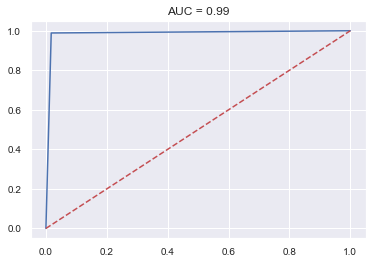

In [55]:
# from sklearn.model_selection import cross_val_score

# Modelo
tree_mod = DecisionTreeClassifier(criterion="gini")\
                .fit(x_train[["num_dt_bin", "financiacion_SI", "incidencia_SI", "descuentos_SI", "imp_financ"]], y_train)

# Predicciones
tree_pred = tree_mod.predict(x_test[["num_dt_bin", "financiacion_SI", "incidencia_SI", "descuentos_SI", "imp_financ"]])

# Métricas:
obtener_metricas(y_test, tree_pred)

In [56]:
# Validación cruzada
cv = cross_val_score(
    tree_mod,
    x_train[["num_dt_bin", "financiacion_SI", "incidencia_SI", "descuentos_SI", "imp_financ"]], 
    y_train,
    scoring = "roc_auc",
    cv = 5
)

print("AUC after 5 cross validations: {}, with standard deviation {}".format(cv.mean(), round(np.std(cv), 4)))

AUC after 5 cross validations: 0.9895243889190661, with standard deviation 0.0017


Pese a haber utilizado validación cruzada, los resultados obtenidos simplemente por incluir las variables verdaderamente significativas son excesivamente buenos y la desviación típica es prácticamente nula. Esto se debe a que al ser datos sintéticos, los clientes acaban siendo muy parecidos entre sí, por tanto, incluso da igual la partición que hagas, que las predicciones no se van a desviar y será fácil obtener muy buenos resultados. 

Aún con todo esto, realizaremos varias técnicas de feature engineering, análisis de variables, testeo de overfitting, oversampling y tuneado de hiperparámetros de nuestro modelo para tratar de mejorar el resultado, así como de prácticar.

## 5. Técnicas de mejora de modelo

### 5.1 Selección de variables.

In [57]:
# Seleccionamos unicamente los datos de diciembre 
data_dic = data_dummy[data_dummy["mes"]=="dic"]

# Eliminamos la columna "mes"
data_dic = data_dic.loc[:,data_dic.columns != "mes"]
data_dic.shape

(95467, 58)

- __Varianza__

En primer lugar comprobaremos si entre nuestros datos existen variables con una varianza casi nula. Son variables que a penas aportarían información al modelo. Para ellos utilizaremos VarianceThreshold de sklearn.

In [58]:
# from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.05):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

data_dic = variance_threshold_selector(data_dic)
data_dic.shape[1]

49

Hemos descartado nueve variables, puesto que éstas presentaban una varianza inferior a 0.05 y probablemente no aportaban información al modelo.

- __Realizaremos ahora una selección basada en la $ X^{2} $__

In [59]:
# from sklearn.feature_selection import SelectKBest 
# from sklearn.feature_selection import chi2 

S_chi5 = SelectKBest(chi2, k = 6)
X_chi5 = S_chi5.fit_transform(data_dic, data_dic['churn'])

variables = list(np.asarray(list(data_dic))[S_chi5.get_support()])
variables.sort()
print('Variables más importantes según la chi2: \n{}'.format(variables))

Variables más importantes según la chi2: 
['churn', 'descuentos_SI', 'imp_financ', 'incidencia_SI', 'num_dt', 'num_dt_bin']


- __V de Crammer__

Calcularemos ahora las variables más importantes según la V de Crammer. No obstante, anticipamos que los resultados serán idénticos a los anteriores ya que por debajo se calcula la $ X^{2} $.

In [60]:
cramers_v_graphic(data_dic, data_dic["churn"], graph=False).head(7).style.background_gradient()

,CramersV
churn,0.999924
num_dt,0.560547
num_dt_bin,0.560423
incidencia_SI,0.500789
descuentos_SI,0.141361
financiacion_SI,0.074447
imp_financ,0.070821


- __Random Forest__

El modelo de Random Forest se puede aplicar a selección de variables, dado que este modelo estima las variables que más reducen el índice de Gini.
\begin{align}
    I(N)=2*P*(1-P)
\end{align}    

Random Forest guardan las variables que más han reducido el índice de Gini, y por tanto, aquellas con más capacidad para discriminar.

Construir un modelo con 50 árboles ya es suficiente, puesto que solo se quiere medir la importancia. El número de variables que entran a los árboles por defecto es la raiz cuadrada del número de variables (en nuestro caso tenemos 49 variables, por lo que utlizará 7).

__Resultado__: num_dt, num_dt_bin, incidencia_SI, descuento_SI y vemos que finanaciación_SI queda atrás.

Sin embargo, hay que tener cuidado porque un Random Forest percive relaciones no lineales que una logística no es capaz, excepto que la variable esté tramificada.

In [61]:
# from sklearn.ensemble import RandomForestClassifier

impRF = RandomForestClassifier(n_estimators=50, criterion="gini", random_state=23)
x, y = data_dic.drop("churn", axis=1), data_dic["churn"] 
impRF.fit(x, y)

imp = {}

for i in range(len(x.columns)):
    imp[x.columns[i]] = [impRF.feature_importances_[i]]
    
pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"])\
            .sort_values("Importance", ascending=False).head(10).style.background_gradient()

,Importance
incidencia_SI,0.276900
num_dt_bin,0.192734
num_dt,0.165131
descuentos_SI,0.091755
id,0.019560
seg_llamad_ent,0.019364
mb_datos,0.019168
seg_llamad_sal,0.019122
facturacion,0.018703
duracion,0.018553


- __Recursive Feature Extraction__
        - step: Nº de variables que elimina en cada iteración.
        - cv: Se hace estratificada para que tenga en cuenta la variable objetivo a hacer la validación cruzada.
        - Está comentado porque es un poco lento, resultados:
            'num_dt_bin', 'imp_financ', 'incidencia_SI', 'financiacion_SI','descuentos_SI', 'month_December', 'month_July'

In [62]:
# from sklearn.feature_selection import RFECV
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import StratifiedKFold

impLog = LogisticRegression(solver="liblinear")
rfe = RFECV(impLog, step=1, cv= StratifiedKFold(5), scoring="accuracy")
rfe = rfe.fit(x, y.values.ravel())
x.columns[rfe.get_support()]

Index(['imp_financ', 'num_dt_bin', 'incidencia_SI', 'financiacion_SI',
       'descuentos_SI', 'month_December', 'month_July'],
      dtype='object')

In [63]:
# plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
# plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
# plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
# plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_, color='#303F9F', linewidth=2)
# plt.savefig("recursive.png")

### 5.2 Train/Test con las nuevas variables

Nuevamente, volveremos a dividir los datos de diciembre en conjuntos de train y test. No obstante, esta vez sólo consideraremos las 4 features que se han mostrado importantes a lo largo de este apartado. Éstas son: num_dt_bin, incidencia_SI, descuentos_SI y financiacion_SI. 

Nuevamente, llevaremos a cabo un muestreo estratificado en función de la variable respuesta para que en los splits sus categorías estén bien representadas (split 80/20).

In [64]:
x, y = data_dic[['num_dt_bin', 'incidencia_SI', 'financiacion_SI', 'descuentos_SI']], data_dic["churn"] 

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=23, stratify=y, test_size=.2) 

### 5.3 Selección de modelos

Evaluaremos varios modelos sin customizar sus hiperparámetros, solo los necesarios.

Generalmente es necesario escalar las features para utilizar Lasso y Ridge. Incluso es conveniente también para SVM, ya que están basados en productos escalares (distancias). Si se desea, se debe usar MinMax Scaler porque deja intactas las variables dummy debido a que:

\begin{align}
x_{scaled} = \dfrac{x - min}{max-min};
\dfrac{1 - 0}{1-0} = 1;
\dfrac{0 - 0}{1-0} = 0
\end{align}


<font color=red>__No obstante descartamos algún tipo de escalado pues todas las variables seleccionadas son categóricas.__</font>

- Una ventaja a destacar de LassoCV y RidgeCV es que ya optimizan el parámetro de penalización por CV solos.

- También es necesario comentar que con tan pocas variables y tan poco correlacionadas, Lasso o Ridge no son tan útiles, ya que cuando mejor funcionan es en problemas de alta dimensionalidad.

Como trabajaremos con cuatro variables, se suele empezar a buscar por 4*10 árboles en Random Forest y XGboost.

In [65]:
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.svm import SVC
# from sklearn.svm import LinearSVC
# from xgboost import XGBClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.linear_model import LassoCV
# from sklearn.linear_model import RidgeClassifierCV

models_rcv = {
    "XGB": XGBClassifier(n_jobs=-1, n_estimators=40, random_state=23),
    "AdaBoost":AdaBoostClassifier(algorithm="SAMME.R", n_estimators=40, random_state=23),
    "RF": RandomForestClassifier(n_estimators =40, n_jobs=-1, random_state=23),
    "Tree": DecisionTreeClassifier(random_state=23),
    "LSVM": LinearSVC(random_state=23),
    "Log": LogisticRegression(solver="liblinear"),
    "Lasso": LassoCV(),
    "Ridge": RidgeClassifierCV(alphas=(0.1, 0.5, 1, 2, 10)),
    "NB": GaussianNB()
}

def rskf_comparison(models, x_train, y_train):
    
    results = []
    names = []

    for k, v in models.items():
    
        rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=23) 
        cv_scores = cross_val_score(v, x_train, y_train, scoring='roc_auc', cv=rskf, n_jobs=-1)

        results.append(cv_scores)
        names.append(k)

        print(k)
        print('CV AUC: %.5f +/- %.5f' % (np.mean(cv_scores), np.std(cv_scores)))
        print('-------------------------')
        
    
    return(results, names)

XGB
CV AUC: 0.98906 +/- 0.00153
-------------------------
AdaBoost
CV AUC: 0.98766 +/- 0.00213
-------------------------
RF
CV AUC: 0.98908 +/- 0.00153
-------------------------
Tree
CV AUC: 0.98909 +/- 0.00154
-------------------------
LSVM
CV AUC: 0.98840 +/- 0.00205
-------------------------
Log
CV AUC: 0.98835 +/- 0.00208
-------------------------
Lasso
CV AUC: 0.98766 +/- 0.00214
-------------------------
Ridge
CV AUC: 0.98766 +/- 0.00214
-------------------------
NB
CV AUC: 0.98873 +/- 0.00200
-------------------------


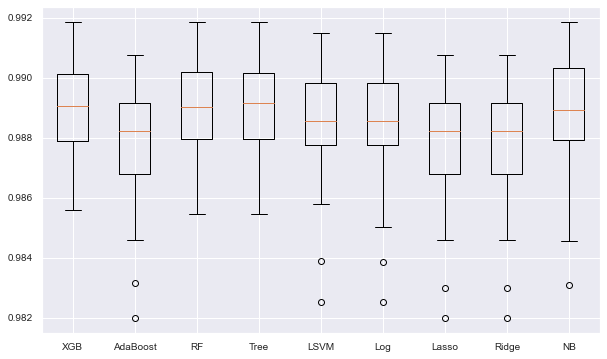

In [66]:
results, names = rskf_comparison(models_rcv, x_train, y_train)

plt.figure(figsize=(10, 6))

comparison = plt.boxplot(results)

plt.xticks(np.arange(1,len(names)+1), names)
plt.show(comparison)

__Notas__:
   - Antes las métricas tan altas que veníamos obteniendo, hemos decidido utilizar validación cruzada repetida estratificada, para balancear los problemas de partición de la semilla.
   - Parece que XGB, Random Forest, Decision Tree y Naive Bayes son los mejores modelos, aunque la diferencia no es significativa. Si bien es cierto que los modelos no están optimizados.
   - Menos Adaboost, Lasso y Ridge todos son muy parecidos.
   - Los resultados indican que ningún modelo es claramente superior a otro. 
   - Es necesario resaltar que solo estamos utilizando variables dicotómicas, por lo que los algoritmos de árboles no van a captar relacciones no linales.
   - Los resultados obtenidos son muy altos y la desviación típica es muy reducida. __Volvemos a señalar que es producido porque los datos son sintéticos, lo que ha dado lugar a clientes muy parecidos entre sí.__ Consecuentemente, independientemente del número de folds en que se divida, siempre obtendremos muestras parecidas, dando lugar a una varianza reducida.
   - Si bien es cierto que con métricas tan altas se debe sospechar de overfitting, resulta poco creible que una regresión logística con 4 variables esté sobreajustada incluso tras haber hecho validación cruzada.

__Como no hay grandes diferencias entre los modelos considerados, optaremos por modelos sencillos, como son el Árbol de Decisión y la Regresión Logística.__

### 5.4 Feature Engineering

Antes de comenzar este apartado, hemos de recordar que todas las variables que hemos seleccionado son binarias, por lo que no podremos hacer grandes cambios sobre estas features más allá de forzar interacciones entre ellas. Además, las interacciones entre variables ya son capturadas por los algoritmos basados en árboles, por lo que este cambio sólo podría mejorar modelos como la Regresión Logística.

Dadas las variables que hemos considerado, trataremos de recoger un efecto de interacción entre variables de descuento y líneas en impago, puesto que sospechamos que la concurrencia de no tener descuentos y tener líneas en impago puede tener un efecto adicional sobre la posibilidad de fuga de un cliente.

In [67]:
# Trabajamos con los datos de ambos meses para aplicar las mismas transformaciones a train y test
data_fe = data_dummy[["num_dt_bin", "incidencia_SI", "financiacion_SI", "descuentos_SI", "churn", "mes"]]

In [68]:
# Tabla de contingencia entre num_dt_bin y descuentos
pd.crosstab(data_fe.descuentos_SI, data_fe.num_dt_bin)

num_dt_bin,0,1
descuentos_SI,,
0,142528,6458
1,36519,2673


c:\Users\Javier\Desktop\Proyectos\flex\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Javier\Desktop\Proyectos\flex\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Javier\Desktop\Proyectos\flex\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

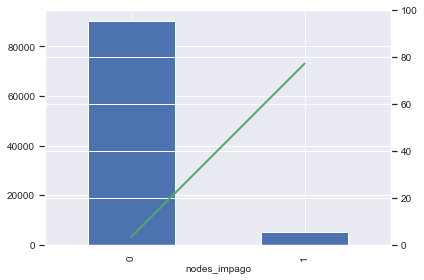

In [69]:
# Creamos la interaccion
data_fe.loc[:,"nodes_impago"] = 0
data_fe.loc[(data_fe.descuentos_SI==0) & (data_fe.num_dt_bin==1), ["nodes_impago"]] = 1

# Graficamos su distribución frente a la de la target
proporciones_final("nodes_impago", "churn", data_fe)

Definitivamente, la nueva interacción parece relevante. No obstante, aún hemos de estudiar en mayor detalle su importancia respecto a la target.

In [70]:
# V de Crammer
cramers_v_graphic(data_fe.drop("mes", axis=1), dic_full["churn"], graph=False).head(10).style.background_gradient()

,CramersV
churn,0.999924
nodes_impago,0.639230
num_dt_bin,0.560423
incidencia_SI,0.500789
descuentos_SI,0.141361
financiacion_SI,0.074447


In [71]:
# Correlation
corr = abs(data_fe[data_fe["mes"]=="dic"].corr("kendall"))
corr[["churn"]].sort_values(by = "churn",ascending = False).style.background_gradient()

,churn
churn,1.000000
nodes_impago,0.639323
num_dt_bin,0.560509
incidencia_SI,0.500885
descuentos_SI,0.141447
financiacion_SI,0.074597


La interacción introducida parece ser relevante hasta ahora. No obstante, dado que "nodes_impago" (no descuento + impago) proviene de "num_dt" y de "descuentos_SI", es probable que la nueva variable de interacción tenga una correlación muy alta con sus componentes, lo que podría dar lugar a problemas de colinealidad. Por tanto, utilizaremos el __VIF__ para testear esto.

Antes de estimar el VIF, observaremos las correlaciones existentes entre nuestras variables.

In [72]:
# Correlaciones
corr = data_fe[data_fe["mes"]=="dic"].drop("churn", axis=1).corr("kendall")
corr

,num_dt_bin,incidencia_SI,financiacion_SI,descuentos_SI,nodes_impago
num_dt_bin,1.000000,-0.002036,-0.008151,-0.000159,0.887711
incidencia_SI,-0.002036,1.000000,-0.000408,-0.001692,-0.000524
financiacion_SI,-0.008151,-0.000408,1.000000,0.005193,-0.008094
descuentos_SI,-0.000159,-0.001692,0.005193,1.000000,-0.120380
nodes_impago,0.887711,-0.000524,-0.008094,-0.120380,1.000000


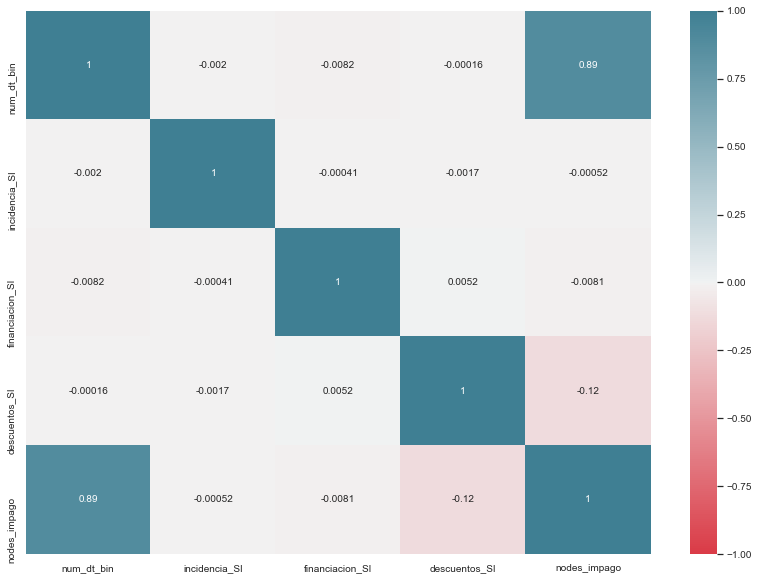

In [73]:
# Graficamos las correlaciones
plt.figure(figsize=(14,10))

fig = sns.heatmap(corr, cbar=True, cmap=sns.diverging_palette(10, 220, as_cmap=True), vmin=-1, annot=True)

Tal y como sospechábamos, la introducción de la interacción ha provocado la existencia de correlación entre nuestras features, por lo que utilizaremos el VIF para comprobar la existencia de colinealidad.

- __VIF__

El VIF (o factor de inflación de la varianza) permite calcular la multicolinealidad. Esto significaría que las variables estarían explicando el mismo porcetaje de varianza y, por tanto, habría redundancia. El problema es que en algunos algoritmos, sobre todo en los lineales, la multicolinealidad produce coeficientes inestables que esconden la verdadera relación de las variables con la target. Las betas tienden a tomar valores grandes, por tanto, métodos de penalizaciones como LASSO o RIDGE pueden ser buenas alernativas.

Al utilizar el VIF, creamos una regresión lineal de cada feature sobre el resto de las features. Por tanto, si se estima un R2 alto, hay relación entre las features: "El R2 es el % de varianza de la variable respuesta (una feature en este caso) que es explicada por el modelo".

\begin{align}
VIF_i = \dfrac{1}{1-R^2} 
\end{align}

\begin{align}
R^2 = 1- \dfrac{\sum^1_i (x_i - \hat{y_i})^2}{\sum^1_i (y_i - \tilde{y})^2} 
\end{align}

- Observando la fórmula:
    1. R2 pequeño ~ 0; 1/1-0 = ~ 1.
    2. R2 grande ~ 0.99; 1/(1-.99=0.01) = ~ 100.
    3. Se considera que a partir de un VIF > 5 podría haber multicolinealidad (corresponde a un R2 de 0.8).

In [74]:
# from sklearn.linear_model import LinearRegression

def calculateVIF(data):
    features = list(data.columns)
    num_features = len(features)
    
    model = LinearRegression()
    
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)
        
        x = data[x_features]
        y = data[y_featue]
        
        model.fit(data[x_features], data[y_featue])
        
        result[y_featue] = 1/(1 - model.score(data[x_features], data[y_featue]))
    
    return result

In [75]:
# Calculamos el VIF
print(calculateVIF(data_fe[data_fe.mes=="dic"].drop(["churn", "mes"], axis=1)))
print(calculateVIF(data_fe[data_fe.mes=="dic"].drop(["churn", "mes", "nodes_impago"], axis=1)))
print(calculateVIF(data_fe[data_fe.mes=="dic"].drop(["churn", "mes", "num_dt_bin"], axis=1)))

     num_dt_bin  incidencia_SI  financiacion_SI  descuentos_SI  nodes_impago
VIF    4.989714       1.000013         1.000094       1.073223      5.063016
     num_dt_bin  incidencia_SI  financiacion_SI  descuentos_SI
VIF    1.000071       1.000007         1.000094        1.00003
     incidencia_SI  financiacion_SI  descuentos_SI  nodes_impago
VIF       1.000004         1.000084       1.014726      1.014762


Observando los resultados del VIF, vemos que "nodes_impago" está justo en límite de 5, además, al eliminarlo confirmamos que los coeficientes disminuyen a niveles de no-colinealidad. No obstante, al estar en el límite de momento lo mantendremos y comprobaremos si nuestros modelos mejoran con esta variable en lugar de "num_dt_bin".

__Creamos nuevos conjuntos de train y test__

In [76]:
data_fe_dic = data_fe[data_fe.mes == "dic"].drop("mes", axis=1)
x_fe, y_fe = data_fe_dic.drop(["churn", "num_dt_bin"], axis=1), data_fe_dic["churn"] 

x_train, x_test, y_train, y_test = train_test_split(x_fe, y_fe, random_state=23, stratify=y_fe, test_size =.2)

__Construimos de nuevo los modelos y evaluamos sus resultados__

XGB
CV AUC: 0.98907 +/- 0.00153
-------------------------
AdaBoost
CV AUC: 0.98840 +/- 0.00205
-------------------------
RF
CV AUC: 0.98907 +/- 0.00154
-------------------------
Tree
CV AUC: 0.98908 +/- 0.00155
-------------------------
LSVM
CV AUC: 0.98823 +/- 0.00219
-------------------------
Log
CV AUC: 0.98822 +/- 0.00222
-------------------------
Lasso
CV AUC: 0.98686 +/- 0.00218
-------------------------
Ridge
CV AUC: 0.98686 +/- 0.00218
-------------------------
NB
CV AUC: 0.98865 +/- 0.00202
-------------------------


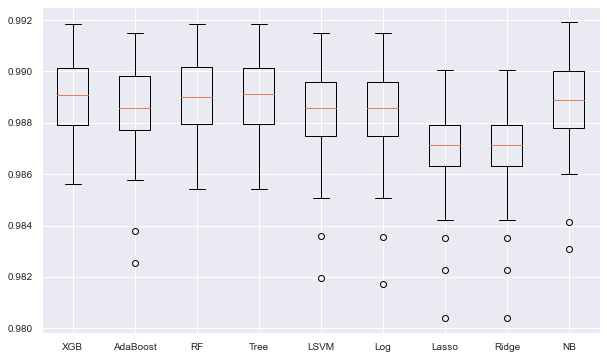

In [77]:
results, names = rskf_comparison(models_rcv, x_train, y_train)

plt.figure(figsize=(10, 6))

comparison = plt.boxplot(results)

plt.xticks(np.arange(1,len(names)+1), names)
plt.show(comparison)

Los principales modelos que podían mejorar tras esta transformación (Lasso, Ridge, Logistic) no sólo no han mejorado, sino que han empeorado míniminamente. El único modelo que ha mostrado una mejora (aunque ínfima) es AdaBoost. 

Por tanto, decidimos descartar esta transformación y conservar la versión anterior de nuestro dataset.

In [78]:
data_fe_dic = data_fe[data_fe.mes == "dic"].drop("mes", axis=1)
x_fe, y_fe = data_fe_dic.drop(["churn", "nodes_impago"], axis=1), data_fe_dic["churn"] 

x_train, x_test, y_train, y_test = train_test_split(x_fe, y_fe, random_state=23, stratify=y_fe, test_size =.2) 

### 5.5 Oversampling

Tal y como vimos en el EDA, la target presenta un claro problema de desbalance. Por ello, sobre todo para mejorar la sensibilidad, puede ser interesante probar técnicas como SMOTE. Pese a que ésta se basa en KNN y este último utiliza distancias, parece ser que SMOTE funciona bien con dummies cuando son binarias. Seguramente las muestras generadas sean copias parecidas a las observaciones, pero probablemente funcione mejor que técnicas como _random over sampling_ , por ejemplo.

- <font color=red>__Un problema que surge cuando se hace oversampling en general, es cómo reportar las métricas con validación cruzada:__</font>
    1. INCORRECTA: Realizar oversampling sobre todo el conjunto de datos a la vez, es decir, aplicar esta técnica a train y test y luego hacer CV. 
        - Tras comprobarlo, el AUC era altísima y la sensibilidad pasaba de 0.82 a 0.99. Obviamente son estimaciones NO honestas ya que estamos testeando con muestras sintéticas.
        - Provoca mucho sobreajuste.
    2. CORRECTA:
        1. Dividir en train/validation k folds. 
        2. A cada fold/partición se le hace el oversampling de la clase minoritaria.
        3. Se entrena el modelo con los training folds.
        4. Se validad con el fold restante.

Por ello, adaptamos esta función creada por otro usuario para aplicar SMOTE de forma correcta.

Referencia: https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

In [79]:
from imblearn.over_sampling import SMOTE

def rskf_comparison_ovs(models, x_train, y_train):
    
    results = []
    names = []

    for k, v in models.items():
    
        rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=23) 
        imba_pipeline = make_pipeline(SMOTE(random_state=23, n_jobs=-1), v)
        cv_scores = cross_val_score(imba_pipeline, x_train, y_train, scoring='roc_auc', cv=rskf, n_jobs=-1)

        results.append(cv_scores)
        names.append(k)

        print(k)
        print('CV AUC: %.5f +/- %.5f' % (np.mean(cv_scores), np.std(cv_scores)))
        print('-----------------------------')
        
    
    return(results, names)

XGB
CV AUC: 0.98909 +/- 0.00159
-----------------------------
AdaBoost
CV AUC: 0.98769 +/- 0.00212
-----------------------------
RF
CV AUC: 0.98911 +/- 0.00157
-----------------------------
Tree
CV AUC: 0.98910 +/- 0.00157
-----------------------------
LSVM
CV AUC: 0.98838 +/- 0.00212
-----------------------------
Log
CV AUC: 0.98842 +/- 0.00206
-----------------------------
Lasso
CV AUC: 0.98766 +/- 0.00214
-----------------------------
Ridge
CV AUC: 0.98766 +/- 0.00214
-----------------------------
NB
CV AUC: 0.98869 +/- 0.00208
-----------------------------


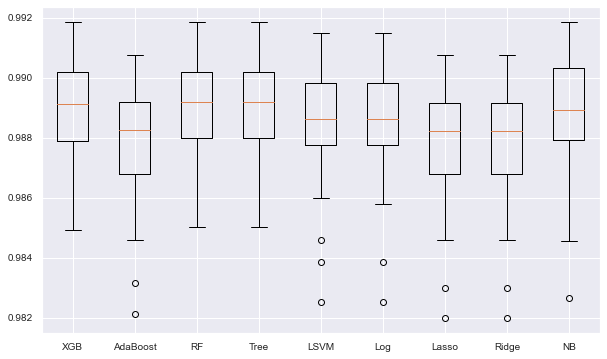

In [80]:
# Construimos de nuevo los modelos considerados, esta vez aplicando SMOTE
results, names = rskf_comparison_ovs(models_rcv, x_train, y_train)

plt.figure(figsize=(10, 6))

comparison = plt.boxplot(results)

plt.xticks(np.arange(1,len(names)+1), names)
plt.show(comparison)

__Resultado:__ Tras aplicar SMOTE a nuestros datos, la mayoría de los modelos considerados han mejorado, aunque de manera ínfima (sólo ha empeorado AdaBoost, de manera insignificante). 

Por tanto, decidimos aplicar SMOTE a nuestros datos e igualar las clases.

In [81]:
x_fe_os, y_fe_os = SMOTE(random_state=23, n_jobs=-1).fit_resample(x_fe, y_fe)

Revisamos ahora que SMOTE no haya generado observaciones incoherentes de 0.95 / 0.03 en lugar de 0 / 1.

In [82]:
# Check
y_fe_os.value_counts()

1.0    88382
0.0    88382
Name: churn, dtype: int64

In [83]:
# Check
for i in x_fe_os.columns:
    print(i, x_fe_os[i].unique())

num_dt_bin [0 1]
incidencia_SI [0 1]
financiacion_SI [0 1]
descuentos_SI [0 1]


<font color=red>__Es importante señalar que no hemos de crear muestras de test, ya que el oversampling solo es necesario para ENTRENAR el modelo, no para evaluarlo, pues esto maquillaría los resultados.__</font>
    
Al splitear de nuevo los datos no es necesario que el muestreo sea estratificado, puesto que las clases ya están balanceadas.

In [84]:
x_over, y_over = x_fe_os, y_fe_os
x_train_over, _, y_train_over, _ = train_test_split(x_over, y_over, random_state=23)

### 5.6 Modelos Finales

A continuación volveremos a construir y entrenar los modelos elegidos anteriormente (Árbol de Decisión y Regresión Logística), esta vez utilizando las variables finalmente elegidas y con SMOTE previamente aplicado, y evaluaremos su capacidad para extraer la información de nuestros datos.

#### 5.6.1 Árbol

- Matriz de confusión:
 [[17372   305]
 [    9  1408]]
- Accuracy: 0.9835550434691526
- Precision/sensibilidad: 0.8219497956800934
- Recall/especificidad: 0.9936485532815809
- F1: 0.8996805111821087
- AUC: 0.9881972471674635


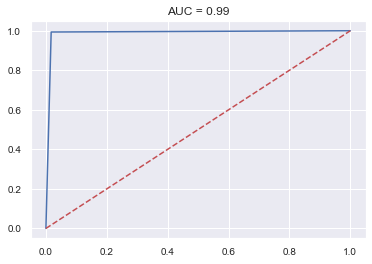

In [85]:
# Entrenamiento:
tree_mod = DecisionTreeClassifier(criterion="gini", max_depth=7).fit(x_train_over, y_train_over)
tree_pred = tree_mod.predict(x_test)

# Métricas:
obtener_metricas(y_test, tree_pred)

In [86]:
# CV:
imba_pipeline = make_pipeline(SMOTE(random_state=23, n_jobs=-1), tree_mod)
cv = cross_val_score(imba_pipeline, x_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1)

print("AUC after 10 cross validations: {}, with standard deviation {}".format(cv.mean(), round(np.std(cv), 5)))

AUC after 10 cross validations: 0.9888038441751179, with standard deviation 0.00127


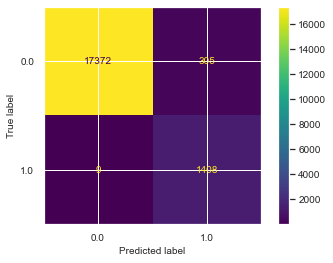

In [87]:
cm = plot_confusion_matrix(tree_mod, x_test, y_test, values_format=".5g")

__Resultados:__
   - Tras las transformaciones realizadas a lo largo de los apartados anteriores, el AUC en TEST de nuestro modelo ha mejorado (aunque la mejora ha sido ínfima).
   - En cuanto a la sensibilidad, ésta también se ha visto mejorada tras las técnicas aplicadas (de nuevo, ínfima).
   - Tras la validación cruzada, el AUC ha disminuido mínimamente (no es si quiera significante), no obstante, su desviación típica también ha mostrado una reducción.

#### 5.6.2 Regresión Logística

Como alternativa al modelo de Árbol de Decisión anterior, hemos escogido un modelo lineal generalizado GLM, el cual presenta las siguientes características:
- Tiene una parte lineal, la de los predictores (como una regresión lineal).
- Utiliza una función link para conectar la variable respuesta con el output de la parte lineal. En este caso es la función logit que transforma las predicciones a probabilidades, es decir, transforma estas predicciones a valores en el rango 0-1.
- No asume normalidad en la distribución de los residuos.
- Es interpretable. En el caso de la logística, las odds tienen una escala lineal.
- Los coeficientes del modelo se estiman por máxima verosimilitud.

<font color=red> Los árboles pueden detectar interacciones entre variables pero la regresión logística no, por tanto, hemos de especificarlas explícitamente. </font>

In [88]:
# import patsy
 
y, x = patsy.dmatrices(
    'churn ~ num_dt_bin + incidencia_SI + financiacion_SI + descuentos_SI + incidencia_SI:financiacion_SI + num_dt_bin:financiacion_SI' 
    , data_dic
)

x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(x, y, random_state=23, stratify=y, test_size=.2) 

Es necesario señalar que para que no se sobreajuste el modelo, hemos incluido únicamente dos interacciones, eligiendo aquellas que ofrecen mejores resultados.

- Matriz de confusión:
 [[17372   305]
 [    9  1408]]
- Accuracy: 0.9835550434691526
- Precision/sensibilidad: 0.8219497956800934
- Recall/especificidad: 0.9936485532815809
- F1: 0.8996805111821087
- AUC: 0.9881972471674635


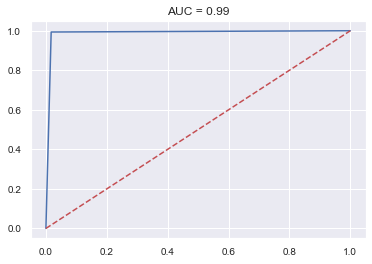

In [89]:
# Entrenamiento
log_mod = LogisticRegression(solver="newton-cg", penalty="none").fit(x_train_log, y_train_log.ravel())

# Predicciones
y_pred  = log_mod.predict(x_test_log)

# Métricas
obtener_metricas(y_test_log, y_pred)

In [90]:
# Validación cruzada
cv = cross_val_score(estimator=log_mod, X=x_train_log, y=y_train_log.ravel(), cv=10, scoring='roc_auc')

print("AUC after 10 cross validations: {}, with standard deviation {}".format(cv.mean(), round(np.std(cv), 5)))

AUC after 10 cross validations: 0.9885057036168761, with standard deviation 0.00199


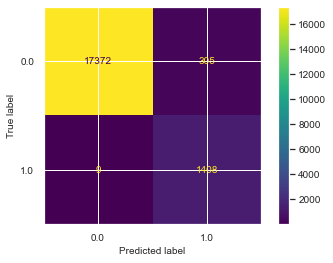

In [91]:
# Matriz de confusión
cm = plot_confusion_matrix(log_mod, x_test_log, y_test_log, values_format=".5g")

__Resultados:__
- Tras las transformaciones realizadas a lo largo de los apartados anteriores, han mejorado (mejora mínima) tanto el AUC como la desviación típica en train tras realizar la validación cruzada.
- Tanto el AUC como la sensibilidad del modelo son prácticamente idénticos a los resultados del modelo de árbol.
- No obstante, tras la validación cruzada vemos que, el AUC del modelo de árbol es ligeramente superior al AUC de la regresión logística (aunque la diferencia de nuevo es ínfima).

#### 5.6.3 Modelo de Bagging: Random Forest

En este apartado elegiremos un modelo de _bagging_ para ver si éste consigue mejorar los resultados obtenidos hasta ahora. Dados los buenos resultados obtenidos con el modelo de árbol, elegiremos __Random Forest__ como nuestro modelo de bagging. Además, una de las principales fortalezas de este modelo es que éste hereda todas las ventajas de los Árboles de Decisión y elimina sus desventajas. No obstante, también es importante señalar que este modelo pierde interpretabilidad frente al modelo de árbol dada la cantidad de árboles que lo componen, además, contiene un importante componente aleatorio. El funcionamiento de este modelo es el siguiente:
   1. Selecciona una muestra aleatoria con reemplazamiento de tamaño N de la muestra original, la cual se usará como conjunto de entrenamiento. El resto de observaciones componen la muestra out-of-bag (OOB), la cual se utilizará para validar.
   2. Construye un árbol basado en la muestra de entrenamiento, seleccionando en cada nodo un subconjunto pequeño de predictores elegidos aleatoriamente.
   3. Repite el proceso un número K de veces, y finalmente, evalúa el modelo basándose en las predicciones y la importancia de cada predictor.
   4. En los problemas de clasificación (como es nuestro caso) el resultado final será la clase más votada entre todos los árboles y su probabilidad asociada estará basada en el número de votos que reciba cada clase.
   5. La importancia de cadad variable se mide como una media de la disminución en el índice de Gini atribuible a cada variable en todos los árboles.

Además de construir el modelo de bagging ya mencionado, Random Forest incluye un gran número de hiperparámetros que nos permiten customizar el algoritmo para adaptarlo a nuestro caso y nuestro datos. Entre los hiperparámetros más importantes a considerar encontramos:
- número de árboles: en nuestro caso comenzaremos a probar en torno a los 40 árboles (4 variables * 10).
- número de variables a considerar para construir los árboles: como en nuestro caso solo estamos trabajando con 4 variables, limitaremos este hiperparámetro a 3 para que los árboles construidos no sean idénticos al modelo de árbol previamente visto.
- criterio de impureza: consideraremos tanto "gini" como "entropy".
- muestreo con reemplazamiento: consideraremos ambos enfoques, con y sin reemplazamiento.
- profundidad máxima de los árboles: consideraremos profundidades máximas de 3 (para que se creen árboles "cortados") y de 15 (para que éstos trabajen sin restricciones).
- class_weight: probaremos "balanced" y "None", ya que nuestras clases están balanceadas tras aplicar SMOTE.
- min_samples_leaf: número mínimo de observaciones que tiene que haber en los nuevos nodos tras hacer una división en base a una variable.

Para considerar todas estas "versiones" de nuestro modelo (tuneado de hiperparámetros), utilizaremos __GridSearchCV__ de sklearn. Utilizando _GridSearchCV_ , podemos evaluar varias combinaciones de hiperparámetros para averiguar los valores de éstos que ofrecen un mejor resultado, además GridSearchCV también incluye una validación cruzada de los resultados de cada conjunto de hiperparámetros con el fin de ofrecer valores robustos.

In [93]:
# from sklearn.model_selection import GridSearchCV

# Construcción del modelo:
rand_forest_model = RandomForestClassifier(random_state=23, n_jobs=-1)

# Valores de hiperparámetros:
grid_param = {
    "criterion": ["gini", "entropy"],
    'n_estimators': [40, 70, 100, 150],
    "max_features":[2, 3],
    "bootstrap" :[True, False],
    "max_depth" :[3, 15],
    "class_weight": ["balanced", None],
    'min_samples_leaf': [1, 10]
}

# Modelo:
model_grid = GridSearchCV(estimator=rand_forest_model,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=10
)

# Entrenamiento y predicciones con SMOTE.
rf = model_grid.fit(x_train_over, y_train_over)
y_pred = rf.predict(x_test) 

- Matriz de confusión:
 [[17372   305]
 [    9  1408]]
- Accuracy: 0.9835550434691526
- Precision/sensibilidad: 0.8219497956800934
- Recall/especificidad: 0.9936485532815809
- F1: 0.8996805111821087
- AUC: 0.9881972471674635


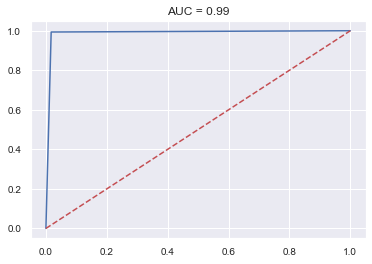

In [94]:
# Métricas
obtener_metricas(y_test, y_pred)

In [95]:
# Validación cruzada
imba_pipeline = make_pipeline(SMOTE(random_state=23, n_jobs=-1), model_grid.best_estimator_)
cv = cross_val_score(imba_pipeline, x_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1)

print("AUC after 10 cross validations: {}, with standard deviation {}".format(cv.mean(), round(np.std(cv), 5)))

AUC after 10 cross validations: 0.9889545994416858, with standard deviation 0.00137


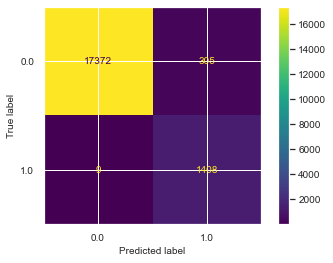

In [96]:
# Matriz de confusión
cm = plot_confusion_matrix(rf, x_test, y_test, values_format=".5g")

Tras entrenar y evaluar nuestro modelo, podemos ver que los resultados son casi idénticos a los que obtuvimos con el modelo de Árbol de Decisión, incluso tras tunear los hiperparámetros (la mínima mejora en AUC es contrarrestada por el aumento de la desviación típica). La matriz de confusión es exactamente idéntica a las de los dos modelos anteriores, lo idóneo sería revisar aquellos casos en los que parecen fallar todos los modelos pero, como venimos mencionando, los datos con los que estamos trabajando son sintéticos.

In [97]:
# Importancia de las variables en función de efecto sobre el indice de Gini
imp = {}

for i in range(len(x_train.columns)):
    imp[x_train.columns[i]] = [model_grid.best_estimator_.feature_importances_[i]]
    
pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"]).sort_values("Importance", ascending=False).style.background_gradient()

,Importance
num_dt_bin,0.510645
incidencia_SI,0.402944
descuentos_SI,0.069249
financiacion_SI,0.017162


Veamos los hiperparámetros seleccionados por GridSearchCV como aquellos que ofrecen mejores resultados.

In [98]:
model_grid.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=2,
                       n_estimators=40, n_jobs=-1, random_state=23)

## 6. Predecir los clientes de la cosecha de diciembre que más probabilidad tienen de cambiarse de operadora

Teniendo en cuenta que el modelo de Random Forest ha ofrecido resultados prácticamente idénticos a los del modelo de Árbol de Decisión, elegiremos el modelo más simple para realizar nuestras predicciones (principio de parsimonia), es decir, el modelo de __Árbol de Decisión__.

In [99]:
# Seleccionamos las variables elegidas anteriormente, esta vez para los clientes de enero
data_en = data_dummy.loc[data_dummy.mes == "en", ["num_dt_bin", "incidencia_SI", "descuentos_SI", "financiacion_SI"]]

In [100]:
# Modelo
tree_mod = DecisionTreeClassifier(criterion="gini", max_depth=5).fit(x_train_over, y_train_over)

# Predicciones
tree_prob = tree_mod.predict_proba(data_en)[:,1]
modelo_prob = (pd.DataFrame(tree_prob, columns=['probabilidad'], index=en_full.index))
modelo_prob.sort_values(by=['probabilidad'], ascending=False, axis=0, inplace=True)

Para saber que clientes son fugas potenciales, hemos de atender a aquellos para los que nuestro modelo estima una probabilidad de fuga superior a la observada, que en nuestro caso es del 7.42%

In [101]:
# Fugas potenciales
modelo_prob[modelo_prob.probabilidad>0.074214]

,probabilidad
74740,0.983376
31567,0.983376
86368,0.983376
68064,0.983376
86367,0.983376
...,...
19277,0.979970
53493,0.979970
30936,0.979970
81992,0.979970


Atendiendo a los resultados, observamos que nuestro modelo estima un total de 1551 clientes (1.67% del total) cuyas características son similares a las de aquellos que abandonaron la empresa (éstos 1551 son fugas potenciales).

Es cierto que las probabilidades estimadas son extremadamente altas para aquellos cuyo perfil coincide con el de fuga, esto podría deberse al SMOTE aplicado previamente. 

<font color=red> Por curiosidad y con el fin de comprender mejor las técnicas que venimos empleando, entrenaremos este mismo modelo sin aplicar previamente SMOTE y compararemos los resultados. </font>

In [102]:
# Modelo
tree_mod = DecisionTreeClassifier(criterion="gini", max_depth=5).fit(x_train, y_train)

# Predicciones
tree_prob = tree_mod.predict_proba(data_en)[:,1]
modelo_prob = (pd.DataFrame(tree_prob, columns=['probabilidad'], index=en_full.index))
modelo_prob.sort_values(by=['probabilidad'], ascending=False, axis=0, inplace=True)

In [103]:
modelo_prob[modelo_prob.probabilidad>0.074214]

,probabilidad
66672,0.825473
66613,0.825473
30955,0.825473
86723,0.825473
65920,0.825473
...,...
74294,0.815668
37746,0.815668
55585,0.815668
38555,0.815668


Como podemos ver tras esta prueba, los resultados en este caso son exactamente iguales independientemente de que apliquemos SMOTE o no. No obstante, vemos como las probabilidades estimadas en el modelo con SMOTE son mucho más extremas, lo que nos indica que el uso previo de SMOTE ayuda al modelo a discriminar mejor los datos (no debe entenderse como sobreajuste).

## 7. Obtener y explicar las claves de la marcha de los clientes en la compañía

Durante el apartado de EDA anterior, graficamos la distribución de todas nuestras variables frente a la target, lo cual nos permitió identificar ciertas relaciones __univariantes__ entre variables. Algunas de las conclusiones que obtuvimos:
- Features que aumentan la probabilidad de fuga:
    - Tener líneas en impago
    - Haber presentado incidencias
    
- Features que disminuyen la probabilidad de fuga:
    - Disponer de descuentos
    - Disponer de financiación
    
Sin embargo, hemos de señalar que mediante el EDA solo podemos descubriri relaciones univariantes de las variables frente a la target, no obstante, gracias a métodos interpretables como la regresión logística y el árbol de decisión ahora podemos cuantificar estos efectos y descubrir relaciones intrínsecas entre variables que hasta ahora no eran apreciables.

### 7.1 Modelo de Árbol para descubrir interacciones

Como ya hemos comprobado, ambos modelos (SMOTE y SIN SMOTE) llegan a las mismas conclusiones, por lo que en este apartado trabajaremos con el modelo SIN SMOTE, ya que es más simple al no contar con muestras sintéticas.

#### 7.1.2 Comprendiendo GINI

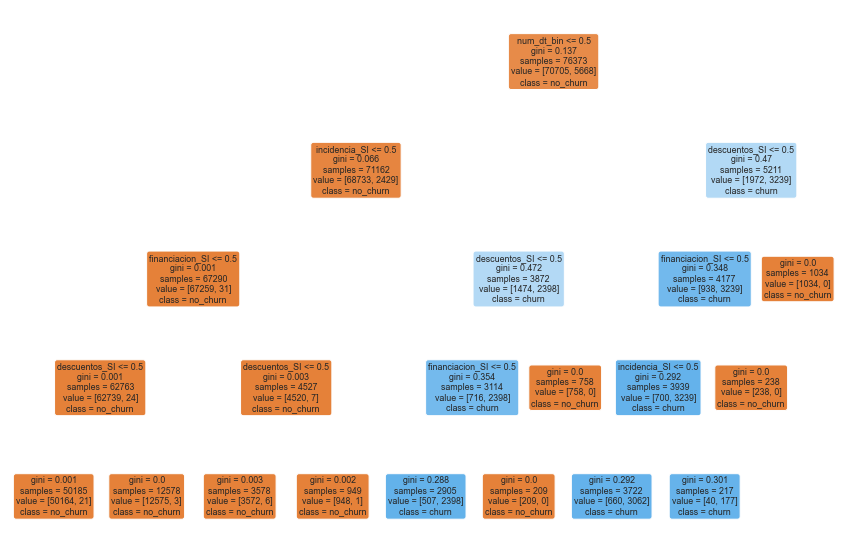

In [136]:
from sklearn import tree

plt.figure(figsize=(15, 10))

_ = tree.plot_tree(tree_mod,
               feature_names=x_train.columns,  
               class_names=['no_churn', 'churn'], 
               filled=True, rounded=True);

# fig.savefig('tree_graph.png')

Fórmula:
\begin{align}
I(N)=2*P*(1-P)
\end{align}
    
1. El primer nodo en la parte superior es el nodo raiz, y lo forman todas las observaciones. Por lo tanto, en este nodo superior GINI se calcula mediante la distribución de las clases de la variable respuesta original, el valor del índice de Gini resultante es de 0.137, tal y como se muestra en el gráfico y al replicar la función mas abajo.

In [130]:
print(y_train.value_counts(normalize=True))
print("\nÍndice de Gini:", 2*.925785*0.074215)

0.0    0.925785
1.0    0.074215
Name: churn, dtype: float64

Índice de Gini: 0.13741426755


2. En siguiente lugar se busca la variable que más minimice el índice de gini, por tanto, la más influyente (num_dt_bin). Si num_dt_bin < 0.5 (o que no haya impago), se dividen las observaciones entre los que cumplan esa condición y los que no. De nuevo, se calcula el índice de Gini para estos grupos, vemos como en aquellos que no tienen líneas en impago Gini baja a 0.066, un valor de Gini bajo que resultará en una buena clasificación. Así, este proceso se repite utilizando aquellas variables ofrecen una mayor reducción del índice hata llegar a los nodos terminales.

In [133]:
# Primer nodo de la parte izquierda, indice de Gini para aquellos con num_dt_bin=0
print(y_train[x_train.loc[x_train["num_dt_bin"]==0, "num_dt_bin"].index].value_counts(normalize=True))
print("\nÍndice de Gini:", 2*0.965867*0.034133)

0.0    0.965867
1.0    0.034133
Name: churn, dtype: float64

Índice de Gini: 0.065935876622


__Relaciones entre variables descubiertas que no se apreciaban con el EDA__:
- Cuando hay líneas en impago, pero hay descuento 1034 clientes se quedaron (todos los de esas características).
- Cuando hay líneas en impago y NO hay descuentos pero SI financiación, los clientes se quedaron (241, todos los de este grupo).
- Cuando NO hay líneas en impago pero SI incidencia, es necesario que haya descuentos o financiación para que los clientes no abandonen la empresa.

### 7.2 ODDS de la Regresión Logística

Las odds (probabilidades) de la regresión logística se encuentran en una escala lineal, por lo tanto se pueden interpretar.

In [137]:
for i in range(1, len(x.design_info.column_names)):
    print(f"{x.design_info.column_names[i]} : {log_mod.coef_[0][i]}") 

num_dt_bin : 8.059183310201947
incidencia_SI : 8.05578097750908
financiacion_SI : 0.3688551610119597
descuentos_SI : -11.89940695531684
incidencia_SI:financiacion_SI : -17.498872995933443
num_dt_bin:financiacion_SI : -17.58047620346766


Sin embargo, para conseguir los ratios de probabilidades hay que hacer la exponencial. Los betas son muy grandes, porque las variables se han generado para tener mucha importancia. El beta más fácil de interpretar es __financiación_SI__:
   - Tener financiación de por sí misma, parece aumentar las odds (de irse de la empresa) ligeramente con respecto a los que no tienen financiación, dejando las demás variables constantes (es decir, comparado a clientes que tengan las mismas características). No obstante, cuando coinciden incidencia_SI e impago_SI con financiación_SI, los coeficientes son muy grandes y negativos, por lo tanto, financiación reduce mucho las probabilidades de irse cuando el cliente tiene líneas en impago o incidencias, como ya vimos en el Árbol de Decisión. El efecto individual de financiacion_SI puede haber sido distorsionado por la presencia de dos interacciones de las que forma parte.

La conclusión es que si bien financiación por si sola reduce ligeramente las odds de fuga, cuando se ocurre a la vez que impago e incidencia es una variable importante para determinar que los clientes no se marchen. Por otra parte, volvemos a ver como haber presentado incidencias o tener líneas en impago aumenta mucho las odds de abandonar la empresa.

### 7.3 Conclusión

1. ¿Por qué los Árboles de Decisión han salido tan bien cuando son métodos que suelen sobreajustarse y perder capacidad de predicción?
    - Al ser datos "de juguete" donde las observaciones son parecidas, los métodos que se sobreajustan tienen ventaja.
2. ¿Por qué LASSO y RIDGE ofrecen resultados claramente peores?
    - Son métodos que están enfocados a situaciones cuando las regresiones no funcionan bien por problemas de multicolinealidad y exceso de variables. En este caso, solo había 4 variables, además sin colinealidad entre sí (como vimos con el VIF). Por lo tanto, la modificación que hacen a los coeficientes suavizan las probabilidades y no obtienen tan buenos resultados.
3. SMOTE apenas produce mejora.
    - Por la misma razón que el punto 1. Las características que diferencian a la categoría menos representada son pocas y claramente diferencia. La clase minoritaria tiene muy poca presencia, pero es muy diferente, por lo tanto, es muy fácil de discriminar.

Javier Ceño Garcia